In [5]:

import matplotlib.pyplot as plt
import numpy as np
from dm_control import viewer
from tqdm import tqdm
from simulation.dm_control.simulation_api import SimulationAPI
import simulation.dm_control.simulation_control.environments as environments
from simulation.dm_control.ddpg.ddpg import DDPGagent, OUNoise

In [6]:
random_state = np.random.RandomState(42)

RESUME_TRAINING = True
PATH_MODEL = 'passive_hand'
NUM_EPISODES = 1000
BATCH_SIZE = 128
DURATION = 100
ACTOR_LEARNING_RATE = 1e-4
CRITIC_LEARNING_RATE = 1e-3
GAMMA = 0.99
TAU = 1e-2

# for parametrization
sapi = SimulationAPI()
sapi.rebuild_XML()
env = environments.load(domain_name='passive_hand', task_name='lift_sparse')
action_spec = env.action_spec()
dim_action = action_spec.shape[0]
dim_obs = 6

updated object_translate
updated object_change_slope
updated robot_change_finger_length
updated robot_change_joint_stiffness
updated robot_change_finger_spring_default
updated robot_change_thumb_spring_default
updated robot_change_friction


In [7]:
def parse_obs(obs):
    """
    Take only gripper position and object position
    """
    x = np.array([])
    x = np.append(x, obs['grip_pos'])
    x = np.append(x, obs['object_pos'])
    return x


agent = DDPGagent(
    dim_obs,
    dim_action,
    actor_learning_rate=ACTOR_LEARNING_RATE,
    critic_learning_rate=CRITIC_LEARNING_RATE,
    gamma=GAMMA,
    tau=TAU
)

if RESUME_TRAINING: agent.load(PATH_MODEL)

noise = OUNoise(dim_action, action_spec.minimum, action_spec.maximum)


def denorm(a):  #  use on model output before passing to env
    act_k = (action_spec.maximum - action_spec.minimum) / 2.
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return a * act_k + act_b

  0%|          | 0/1000 [00:00<?, ?it/s]c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<08:18,  2.01it/s]

episode: 0, reward: -91.57, average_reward: nan


  0%|          | 2/1000 [00:02<26:03,  1.57s/it]

episode: 1, reward: -90.09, average_reward: -91.56642991285578


  0%|          | 3/1000 [00:04<24:17,  1.46s/it]

episode: 2, reward: -92.1, average_reward: -90.82675488182952


  0%|          | 4/1000 [00:05<23:53,  1.44s/it]

episode: 3, reward: -87.96, average_reward: -91.25038996203062


  0%|          | 5/1000 [00:06<23:14,  1.40s/it]

episode: 4, reward: -96.2, average_reward: -90.42860864843358


  1%|          | 6/1000 [00:08<22:38,  1.37s/it]

episode: 5, reward: -100.13, average_reward: -91.5832385323707


  1%|          | 7/1000 [00:09<22:13,  1.34s/it]

episode: 6, reward: -85.97, average_reward: -93.00806459503453


  1%|          | 8/1000 [00:10<21:52,  1.32s/it]

episode: 7, reward: -95.63, average_reward: -92.0027846728707


  1%|          | 9/1000 [00:12<22:02,  1.33s/it]

episode: 8, reward: -91.08, average_reward: -92.45633489776077


  1%|          | 10/1000 [00:13<21:53,  1.33s/it]

episode: 9, reward: -85.39, average_reward: -92.3034393496917


  1%|          | 11/1000 [00:14<21:45,  1.32s/it]

episode: 10, reward: -76.45, average_reward: -91.61199351626809


  1%|          | 12/1000 [00:16<21:43,  1.32s/it]

episode: 11, reward: -95.1, average_reward: -90.10063831004734


  1%|▏         | 13/1000 [00:17<21:40,  1.32s/it]

episode: 12, reward: -94.85, average_reward: -90.60172411748775


  1%|▏         | 14/1000 [00:18<22:18,  1.36s/it]

episode: 13, reward: -92.9, average_reward: -90.87688475635332


  2%|▏         | 15/1000 [00:20<22:14,  1.36s/it]

episode: 14, reward: -103.44, average_reward: -91.37103982049607


  2%|▏         | 16/1000 [00:21<21:58,  1.34s/it]

episode: 15, reward: -103.52, average_reward: -92.09493974971902


  2%|▏         | 17/1000 [00:22<21:45,  1.33s/it]

episode: 16, reward: -68.61, average_reward: -92.43353663756992


  2%|▏         | 18/1000 [00:24<21:37,  1.32s/it]

episode: 17, reward: -83.92, average_reward: -90.69710230612722


  2%|▏         | 19/1000 [00:25<21:29,  1.31s/it]

episode: 18, reward: -84.29, average_reward: -89.52625746179058


  2%|▏         | 20/1000 [00:26<21:17,  1.30s/it]

episode: 19, reward: -57.28, average_reward: -88.8471164637391


  2%|▏         | 21/1000 [00:27<21:10,  1.30s/it]

episode: 20, reward: -95.88, average_reward: -86.03634024009617


  2%|▏         | 22/1000 [00:29<21:01,  1.29s/it]

episode: 21, reward: -102.33, average_reward: -87.9794033002885


  2%|▏         | 23/1000 [00:30<21:06,  1.30s/it]

episode: 22, reward: -93.66, average_reward: -88.70287724064585


  2%|▏         | 24/1000 [00:31<20:40,  1.27s/it]

episode: 23, reward: -101.6, average_reward: -88.58429586915142


  2%|▎         | 25/1000 [00:33<20:41,  1.27s/it]

episode: 24, reward: -91.24, average_reward: -89.45365616994468


  3%|▎         | 26/1000 [00:34<20:23,  1.26s/it]

episode: 25, reward: -102.92, average_reward: -88.23347660366824


  3%|▎         | 27/1000 [00:35<20:10,  1.24s/it]

episode: 26, reward: -100.95, average_reward: -88.17390038721014


  3%|▎         | 28/1000 [00:36<20:31,  1.27s/it]

episode: 27, reward: -86.67, average_reward: -91.40794937465272


  3%|▎         | 29/1000 [00:38<20:46,  1.28s/it]

episode: 28, reward: -70.13, average_reward: -91.68282826732067


  3%|▎         | 30/1000 [00:39<20:50,  1.29s/it]

episode: 29, reward: -94.43, average_reward: -90.26697536150954


  3%|▎         | 31/1000 [00:40<20:38,  1.28s/it]

episode: 30, reward: -101.11, average_reward: -93.98199355308694


  3%|▎         | 32/1000 [00:41<20:43,  1.28s/it]

episode: 31, reward: -90.37, average_reward: -94.50453245377665


  3%|▎         | 33/1000 [00:43<20:31,  1.27s/it]

episode: 32, reward: -101.1, average_reward: -93.30811132309103


  3%|▎         | 34/1000 [00:44<20:23,  1.27s/it]

episode: 33, reward: -105.29, average_reward: -94.05194601509723


  4%|▎         | 35/1000 [00:45<20:26,  1.27s/it]

episode: 34, reward: -97.84, average_reward: -94.42083029023013


  4%|▎         | 36/1000 [00:47<20:42,  1.29s/it]

episode: 35, reward: -92.14, average_reward: -95.08117765697823


  4%|▎         | 37/1000 [00:48<20:34,  1.28s/it]

episode: 36, reward: -101.77, average_reward: -94.00298927606093


  4%|▍         | 38/1000 [00:49<20:30,  1.28s/it]

episode: 37, reward: -100.94, average_reward: -94.08548422578274


  4%|▍         | 39/1000 [00:51<21:51,  1.36s/it]

episode: 38, reward: -86.23, average_reward: -95.51233421691602


  4%|▍         | 40/1000 [00:52<21:58,  1.37s/it]

episode: 39, reward: -87.49, average_reward: -97.12273055635276


  4%|▍         | 41/1000 [00:53<22:18,  1.40s/it]

episode: 40, reward: -88.79, average_reward: -96.42828697603738


  4%|▍         | 42/1000 [00:55<22:12,  1.39s/it]

episode: 41, reward: -96.19, average_reward: -95.19610278425225


  4%|▍         | 43/1000 [00:56<22:35,  1.42s/it]

episode: 42, reward: -95.81, average_reward: -95.77791507708642


  4%|▍         | 44/1000 [00:58<22:38,  1.42s/it]

episode: 43, reward: -93.79, average_reward: -95.24855900347077


  4%|▍         | 45/1000 [00:59<22:23,  1.41s/it]

episode: 44, reward: -75.77, average_reward: -94.09871656751022


  5%|▍         | 46/1000 [01:00<21:41,  1.36s/it]

episode: 45, reward: -101.81, average_reward: -91.89109678164218


  5%|▍         | 47/1000 [01:02<21:06,  1.33s/it]

episode: 46, reward: -104.04, average_reward: -92.8583784100793


  5%|▍         | 48/1000 [01:03<21:11,  1.34s/it]

episode: 47, reward: -94.66, average_reward: -93.08562848418902


  5%|▍         | 49/1000 [01:04<21:03,  1.33s/it]

episode: 48, reward: -84.04, average_reward: -92.45771991407868


  5%|▌         | 50/1000 [01:06<21:08,  1.34s/it]

episode: 49, reward: -92.45, average_reward: -92.23837756956274


  5%|▌         | 51/1000 [01:07<21:12,  1.34s/it]

episode: 50, reward: -103.3, average_reward: -92.73441700715806


  5%|▌         | 52/1000 [01:08<20:58,  1.33s/it]

episode: 51, reward: -101.46, average_reward: -94.18557406582997


  5%|▌         | 53/1000 [01:10<21:36,  1.37s/it]

episode: 52, reward: -85.47, average_reward: -94.71260968778597


  5%|▌         | 54/1000 [01:11<21:20,  1.35s/it]

episode: 53, reward: -98.49, average_reward: -93.67836644991286


  6%|▌         | 55/1000 [01:12<20:45,  1.32s/it]

episode: 54, reward: -99.2, average_reward: -94.14871743600824


  6%|▌         | 56/1000 [01:14<20:35,  1.31s/it]

episode: 55, reward: -85.02, average_reward: -96.49246467483047


  6%|▌         | 57/1000 [01:15<20:31,  1.31s/it]

episode: 56, reward: -83.21, average_reward: -94.81282067964248


  6%|▌         | 58/1000 [01:16<20:21,  1.30s/it]

episode: 57, reward: -92.47, average_reward: -92.72981234083728


  6%|▌         | 59/1000 [01:18<20:28,  1.31s/it]

episode: 58, reward: -90.19, average_reward: -92.51062709055714


  6%|▌         | 60/1000 [01:19<20:24,  1.30s/it]

episode: 59, reward: -91.92, average_reward: -93.12516074727003


  6%|▌         | 61/1000 [01:20<20:05,  1.28s/it]

episode: 60, reward: -103.71, average_reward: -93.0719796701771


  6%|▌         | 62/1000 [01:21<19:46,  1.26s/it]

episode: 61, reward: -102.88, average_reward: -93.112885671469


  6%|▋         | 63/1000 [01:23<19:44,  1.26s/it]

episode: 62, reward: -83.74, average_reward: -93.25555046093517


  6%|▋         | 64/1000 [01:24<19:35,  1.26s/it]

episode: 63, reward: -103.77, average_reward: -93.08269982916818


  6%|▋         | 65/1000 [01:25<19:29,  1.25s/it]

episode: 64, reward: -95.09, average_reward: -93.61010522069704


  7%|▋         | 66/1000 [01:26<20:01,  1.29s/it]

episode: 65, reward: -85.83, average_reward: -93.19897781439208


  7%|▋         | 67/1000 [01:28<20:14,  1.30s/it]

episode: 66, reward: -64.68, average_reward: -93.27988354471424


  7%|▋         | 68/1000 [01:29<20:04,  1.29s/it]

episode: 67, reward: -96.22, average_reward: -91.42606769377558


  7%|▋         | 69/1000 [01:30<20:07,  1.30s/it]

episode: 68, reward: -81.99, average_reward: -91.80138496010132


  7%|▋         | 70/1000 [01:32<20:11,  1.30s/it]

episode: 69, reward: -91.58, average_reward: -90.98161523560736


  7%|▋         | 71/1000 [01:33<20:09,  1.30s/it]

episode: 70, reward: -97.91, average_reward: -90.94818840733826


  7%|▋         | 72/1000 [01:34<19:45,  1.28s/it]

episode: 71, reward: -102.36, average_reward: -90.36880374395935


  7%|▋         | 73/1000 [01:35<19:37,  1.27s/it]

episode: 72, reward: -102.61, average_reward: -90.31614375879454


  7%|▋         | 74/1000 [01:37<19:31,  1.27s/it]

episode: 73, reward: -47.8, average_reward: -92.20354089524014


  8%|▊         | 75/1000 [01:38<19:47,  1.28s/it]

episode: 74, reward: -82.26, average_reward: -86.60659485104745


  8%|▊         | 76/1000 [01:39<19:37,  1.27s/it]

episode: 75, reward: -87.98, average_reward: -85.32303191932404


  8%|▊         | 77/1000 [01:41<19:31,  1.27s/it]

episode: 76, reward: -101.18, average_reward: -85.53874831103708


  8%|▊         | 78/1000 [01:42<19:51,  1.29s/it]

episode: 77, reward: -94.92, average_reward: -89.1894247684069


  8%|▊         | 79/1000 [01:42<16:01,  1.04s/it]

Physics Error: [-1.          0.08285724  0.7897036   1.         -0.75572507]
episode: 78, reward: 436.97, average_reward: -89.05879502041203


  8%|▊         | 80/1000 [01:44<16:53,  1.10s/it]

episode: 79, reward: -103.47, average_reward: -37.16282422661724


  8%|▊         | 81/1000 [01:45<17:44,  1.16s/it]

episode: 80, reward: -90.94, average_reward: -38.35146934345191


  8%|▊         | 82/1000 [01:46<18:12,  1.19s/it]

episode: 81, reward: -94.12, average_reward: -37.65407150657761


  8%|▊         | 83/1000 [01:47<18:35,  1.22s/it]

episode: 82, reward: -95.15, average_reward: -36.83019972528569


  8%|▊         | 84/1000 [01:49<18:47,  1.23s/it]

episode: 83, reward: -83.2, average_reward: -36.08441098225942


  8%|▊         | 85/1000 [01:50<18:53,  1.24s/it]

episode: 84, reward: -93.62, average_reward: -39.62484177982529


  9%|▊         | 86/1000 [01:51<18:57,  1.24s/it]

episode: 85, reward: -91.01, average_reward: -40.76100827829573


  9%|▊         | 87/1000 [01:52<19:09,  1.26s/it]

episode: 86, reward: -91.8, average_reward: -41.063717357225336


  9%|▉         | 88/1000 [01:54<19:10,  1.26s/it]

episode: 87, reward: -88.0, average_reward: -40.125691275027776


  9%|▉         | 89/1000 [01:55<19:14,  1.27s/it]

episode: 88, reward: -89.43, average_reward: -39.43430183276881


  9%|▉         | 90/1000 [01:56<19:08,  1.26s/it]

episode: 89, reward: -103.27, average_reward: -92.07410342650698


  9%|▉         | 91/1000 [01:58<19:10,  1.27s/it]

episode: 90, reward: -49.44, average_reward: -92.05474552891947


  9%|▉         | 92/1000 [01:59<18:57,  1.25s/it]

episode: 91, reward: -102.16, average_reward: -87.90495290704736


  9%|▉         | 93/1000 [02:00<18:38,  1.23s/it]

episode: 92, reward: -101.66, average_reward: -88.70884198599367


  9%|▉         | 94/1000 [02:01<18:47,  1.24s/it]

episode: 93, reward: -78.28, average_reward: -89.3593635167081


 10%|▉         | 95/1000 [02:02<18:38,  1.24s/it]

episode: 94, reward: -100.96, average_reward: -88.8669506281332


 10%|▉         | 96/1000 [02:04<18:32,  1.23s/it]

episode: 95, reward: -103.41, average_reward: -89.60069917273204


 10%|▉         | 97/1000 [02:05<18:40,  1.24s/it]

episode: 96, reward: -94.84, average_reward: -90.84048669693576


 10%|▉         | 98/1000 [02:06<18:42,  1.24s/it]

episode: 97, reward: -93.4, average_reward: -91.14390328124027


 10%|▉         | 99/1000 [02:07<18:33,  1.24s/it]

episode: 98, reward: -102.07, average_reward: -91.68411688115084


 10%|█         | 100/1000 [02:09<18:48,  1.25s/it]

episode: 99, reward: -93.18, average_reward: -92.94799006448666


 10%|█         | 101/1000 [02:10<18:47,  1.25s/it]

episode: 100, reward: -93.37, average_reward: -91.93896322375983


 10%|█         | 102/1000 [02:11<18:54,  1.26s/it]

episode: 101, reward: -81.31, average_reward: -96.33142342843112


 10%|█         | 103/1000 [02:12<18:44,  1.25s/it]

episode: 102, reward: -88.09, average_reward: -94.2470413944425


 10%|█         | 104/1000 [02:14<18:36,  1.25s/it]

episode: 103, reward: -102.47, average_reward: -92.89057335846276


 10%|█         | 105/1000 [02:15<18:42,  1.25s/it]

episode: 104, reward: -91.14, average_reward: -95.31013296121874


 11%|█         | 106/1000 [02:16<18:54,  1.27s/it]

episode: 105, reward: -95.95, average_reward: -94.32885769199383


 11%|█         | 107/1000 [02:17<18:45,  1.26s/it]

episode: 106, reward: -91.04, average_reward: -93.58313595224054


 11%|█         | 108/1000 [02:19<18:50,  1.27s/it]

episode: 107, reward: -91.75, average_reward: -93.20369668958242


 11%|█         | 109/1000 [02:20<18:42,  1.26s/it]

episode: 108, reward: -102.88, average_reward: -93.03810573107219


 11%|█         | 110/1000 [02:21<18:44,  1.26s/it]

episode: 109, reward: -93.07, average_reward: -93.11910278282062


 11%|█         | 111/1000 [02:23<18:44,  1.27s/it]

episode: 110, reward: -97.21, average_reward: -93.10776812845597


 11%|█         | 112/1000 [02:24<18:42,  1.26s/it]

episode: 111, reward: -84.33, average_reward: -93.49163122022375


 11%|█▏        | 113/1000 [02:25<18:30,  1.25s/it]

episode: 112, reward: -101.86, average_reward: -93.79332596615961


 11%|█▏        | 114/1000 [02:26<18:36,  1.26s/it]

episode: 113, reward: -77.18, average_reward: -95.16971514506989


 12%|█▏        | 115/1000 [02:28<18:29,  1.25s/it]

episode: 114, reward: -67.36, average_reward: -92.63998116724484


 12%|█▏        | 116/1000 [02:29<18:24,  1.25s/it]

episode: 115, reward: -103.81, average_reward: -90.26181631149203


 12%|█▏        | 117/1000 [02:30<18:21,  1.25s/it]

episode: 116, reward: -99.84, average_reward: -91.04741716908418


 12%|█▏        | 118/1000 [02:31<18:30,  1.26s/it]

episode: 117, reward: -80.63, average_reward: -91.926849579541


 12%|█▏        | 119/1000 [02:33<18:29,  1.26s/it]

episode: 118, reward: -86.32, average_reward: -90.81501769142028


 12%|█▏        | 120/1000 [02:34<18:29,  1.26s/it]

episode: 119, reward: -92.76, average_reward: -89.15971228778304


 12%|█▏        | 121/1000 [02:35<18:13,  1.24s/it]

episode: 120, reward: -102.72, average_reward: -89.12869813391873


 12%|█▏        | 122/1000 [02:36<18:38,  1.27s/it]

episode: 121, reward: -93.3, average_reward: -89.67979464480472


 12%|█▏        | 123/1000 [02:38<18:43,  1.28s/it]

episode: 122, reward: -93.7, average_reward: -90.57699383598563


 12%|█▏        | 124/1000 [02:39<18:49,  1.29s/it]

episode: 123, reward: -89.4, average_reward: -89.76082524335206


 12%|█▎        | 125/1000 [02:40<18:52,  1.29s/it]

episode: 124, reward: -86.28, average_reward: -90.98360894189112


 13%|█▎        | 126/1000 [02:42<18:30,  1.27s/it]

episode: 125, reward: -102.33, average_reward: -92.8754468185194


 13%|█▎        | 127/1000 [02:43<18:17,  1.26s/it]

episode: 126, reward: -97.01, average_reward: -92.72766023229896


 13%|█▎        | 128/1000 [02:44<18:20,  1.26s/it]

episode: 127, reward: -86.54, average_reward: -92.44493926863417


 13%|█▎        | 129/1000 [02:45<18:07,  1.25s/it]

episode: 128, reward: -102.05, average_reward: -93.03579431214123


 13%|█▎        | 130/1000 [02:47<18:16,  1.26s/it]

episode: 129, reward: -93.75, average_reward: -94.60855536085995


 13%|█▎        | 131/1000 [02:48<18:29,  1.28s/it]

episode: 130, reward: -94.86, average_reward: -94.70775933952012


 13%|█▎        | 132/1000 [02:49<18:11,  1.26s/it]

episode: 131, reward: -99.64, average_reward: -93.92242538575695


 13%|█▎        | 133/1000 [02:50<18:12,  1.26s/it]

episode: 132, reward: -94.99, average_reward: -94.55586841507561


 13%|█▎        | 134/1000 [02:52<18:16,  1.27s/it]

episode: 133, reward: -95.25, average_reward: -94.68570121366953


 14%|█▎        | 135/1000 [02:53<18:18,  1.27s/it]

episode: 134, reward: -84.49, average_reward: -95.27052874282091


 14%|█▎        | 136/1000 [02:54<18:08,  1.26s/it]

episode: 135, reward: -101.43, average_reward: -95.091722461773


 14%|█▎        | 137/1000 [02:55<18:14,  1.27s/it]

episode: 136, reward: -87.44, average_reward: -95.00169305649607


 14%|█▍        | 138/1000 [02:57<18:02,  1.26s/it]

episode: 137, reward: -100.34, average_reward: -94.04503599277783


 14%|█▍        | 139/1000 [02:58<18:02,  1.26s/it]

episode: 138, reward: -85.63, average_reward: -95.42532879122547


 14%|█▍        | 140/1000 [02:59<18:04,  1.26s/it]

episode: 139, reward: -49.59, average_reward: -93.7835077080203


 14%|█▍        | 141/1000 [03:00<17:55,  1.25s/it]

episode: 140, reward: -101.01, average_reward: -89.36691965376978


 14%|█▍        | 142/1000 [03:02<18:00,  1.26s/it]

episode: 141, reward: -92.28, average_reward: -89.98180871206742


 14%|█▍        | 143/1000 [03:03<17:52,  1.25s/it]

episode: 142, reward: -104.65, average_reward: -89.24615577306757


 14%|█▍        | 144/1000 [03:04<18:03,  1.27s/it]

episode: 143, reward: -76.24, average_reward: -90.21206643433723


 14%|█▍        | 145/1000 [03:05<17:46,  1.25s/it]

episode: 144, reward: -104.23, average_reward: -88.31126128412724


 15%|█▍        | 146/1000 [03:07<17:49,  1.25s/it]

episode: 145, reward: -86.27, average_reward: -90.28478228285674


 15%|█▍        | 147/1000 [03:08<18:00,  1.27s/it]

episode: 146, reward: -93.17, average_reward: -88.76859363138321


 15%|█▍        | 148/1000 [03:09<18:05,  1.27s/it]

episode: 147, reward: -101.19, average_reward: -89.34103623712494


 15%|█▍        | 149/1000 [03:11<17:59,  1.27s/it]

episode: 148, reward: -101.58, average_reward: -89.42603312793315


 15%|█▌        | 150/1000 [03:12<17:54,  1.26s/it]

episode: 149, reward: -102.61, average_reward: -91.02123880625935


 15%|█▌        | 151/1000 [03:13<18:02,  1.28s/it]

episode: 150, reward: -92.56, average_reward: -96.32338843724384


 15%|█▌        | 152/1000 [03:14<17:56,  1.27s/it]

episode: 151, reward: -103.2, average_reward: -95.47822890754867


 15%|█▌        | 153/1000 [03:16<17:59,  1.27s/it]

episode: 152, reward: -98.64, average_reward: -96.57054340105084


 15%|█▌        | 154/1000 [03:17<17:58,  1.28s/it]

episode: 153, reward: -101.12, average_reward: -95.96870731973081


 16%|█▌        | 155/1000 [03:18<17:55,  1.27s/it]

episode: 154, reward: -92.01, average_reward: -98.45649009921385


 16%|█▌        | 156/1000 [03:20<18:21,  1.31s/it]

episode: 155, reward: -84.69, average_reward: -97.23507864748589


 16%|█▌        | 157/1000 [03:21<18:22,  1.31s/it]

episode: 156, reward: -86.25, average_reward: -97.0776467969055


 16%|█▌        | 158/1000 [03:22<18:12,  1.30s/it]

episode: 157, reward: -102.17, average_reward: -96.3858654110741


 16%|█▌        | 159/1000 [03:23<18:12,  1.30s/it]

episode: 158, reward: -93.92, average_reward: -96.48337427328897


 16%|█▌        | 160/1000 [03:25<18:45,  1.34s/it]

episode: 159, reward: -94.21, average_reward: -95.71681685343248


 16%|█▌        | 161/1000 [03:26<18:43,  1.34s/it]

episode: 160, reward: -94.65, average_reward: -94.8766227514365


 16%|█▌        | 162/1000 [03:28<18:38,  1.33s/it]

episode: 161, reward: -103.02, average_reward: -95.08533055908504


 16%|█▋        | 163/1000 [03:29<18:20,  1.31s/it]

episode: 162, reward: -47.24, average_reward: -95.06718414106601


 16%|█▋        | 164/1000 [03:30<18:18,  1.31s/it]

episode: 163, reward: -95.64, average_reward: -89.92803662967883


 16%|█▋        | 165/1000 [03:31<18:23,  1.32s/it]

episode: 164, reward: -92.85, average_reward: -89.38013622508198


 17%|█▋        | 166/1000 [03:33<18:24,  1.32s/it]

episode: 165, reward: -94.11, average_reward: -89.46369812089927


 17%|█▋        | 167/1000 [03:34<18:11,  1.31s/it]

episode: 166, reward: -99.79, average_reward: -90.4056166962541


 17%|█▋        | 168/1000 [03:35<18:01,  1.30s/it]

episode: 167, reward: -102.14, average_reward: -91.75996196353464


 17%|█▋        | 169/1000 [03:37<17:47,  1.29s/it]

episode: 168, reward: -99.12, average_reward: -91.75709819643575


 17%|█▋        | 170/1000 [03:38<17:39,  1.28s/it]

episode: 169, reward: -103.02, average_reward: -92.27676867404588


 17%|█▋        | 171/1000 [03:39<17:41,  1.28s/it]

episode: 170, reward: -86.2, average_reward: -93.15859138440756


 17%|█▋        | 172/1000 [03:40<17:35,  1.27s/it]

episode: 171, reward: -102.58, average_reward: -92.3138248140307


 17%|█▋        | 173/1000 [03:42<17:22,  1.26s/it]

episode: 172, reward: -102.57, average_reward: -92.26955485765919


 17%|█▋        | 174/1000 [03:43<17:27,  1.27s/it]

episode: 173, reward: -89.85, average_reward: -97.8018086101537


 18%|█▊        | 175/1000 [03:44<17:34,  1.28s/it]

episode: 174, reward: -95.18, average_reward: -97.2228078378911


 18%|█▊        | 176/1000 [03:45<17:36,  1.28s/it]

episode: 175, reward: -84.71, average_reward: -97.45578915815642


 18%|█▊        | 177/1000 [03:47<17:20,  1.26s/it]

episode: 176, reward: -100.89, average_reward: -96.51513359643181


 18%|█▊        | 178/1000 [03:48<17:21,  1.27s/it]

episode: 177, reward: -94.28, average_reward: -96.62473613363622


 18%|█▊        | 179/1000 [03:49<17:25,  1.27s/it]

episode: 178, reward: -91.47, average_reward: -95.83910053016474


 18%|█▊        | 180/1000 [03:51<17:25,  1.27s/it]

episode: 179, reward: -75.54, average_reward: -95.07467054351892


 18%|█▊        | 181/1000 [03:52<17:22,  1.27s/it]

episode: 180, reward: -90.24, average_reward: -92.32648727037943


 18%|█▊        | 182/1000 [03:53<17:20,  1.27s/it]

episode: 181, reward: -95.46, average_reward: -92.73074307562463


 18%|█▊        | 183/1000 [03:54<17:08,  1.26s/it]

episode: 182, reward: -99.49, average_reward: -92.018525867588


 18%|█▊        | 184/1000 [03:56<17:12,  1.27s/it]

episode: 183, reward: -83.67, average_reward: -91.71054087094029


 18%|█▊        | 185/1000 [03:57<17:07,  1.26s/it]

episode: 184, reward: -101.27, average_reward: -91.09192690949997


 19%|█▊        | 186/1000 [03:58<17:15,  1.27s/it]

episode: 185, reward: -96.78, average_reward: -91.70093815796201


 19%|█▊        | 187/1000 [03:59<17:24,  1.28s/it]

episode: 186, reward: -77.56, average_reward: -92.90843214984329


 19%|█▉        | 188/1000 [04:01<17:24,  1.29s/it]

episode: 187, reward: -79.77, average_reward: -90.57511450103824


 19%|█▉        | 189/1000 [04:02<17:07,  1.27s/it]

episode: 188, reward: -102.4, average_reward: -89.12431291763474


 19%|█▉        | 190/1000 [04:03<17:04,  1.26s/it]

episode: 189, reward: -85.83, average_reward: -90.21750905710805


 19%|█▉        | 191/1000 [04:05<17:10,  1.27s/it]

episode: 190, reward: -87.83, average_reward: -91.24664736391992


 19%|█▉        | 192/1000 [04:06<17:19,  1.29s/it]

episode: 191, reward: -94.52, average_reward: -91.00556935434426


 19%|█▉        | 193/1000 [04:07<17:33,  1.31s/it]

episode: 192, reward: -71.07, average_reward: -90.91212052940384


 19%|█▉        | 194/1000 [04:08<17:30,  1.30s/it]

episode: 193, reward: -94.49, average_reward: -88.07005025430239


 20%|█▉        | 195/1000 [04:10<17:27,  1.30s/it]

episode: 194, reward: -87.18, average_reward: -89.15216174468137


 20%|█▉        | 196/1000 [04:11<17:22,  1.30s/it]

episode: 195, reward: -91.86, average_reward: -87.74359299635047


 20%|█▉        | 197/1000 [04:12<17:11,  1.28s/it]

episode: 196, reward: -102.99, average_reward: -87.25150482655076


 20%|█▉        | 198/1000 [04:14<16:55,  1.27s/it]

episode: 197, reward: -101.46, average_reward: -89.7946501615633


 20%|█▉        | 199/1000 [04:15<17:06,  1.28s/it]

episode: 198, reward: -93.06, average_reward: -91.9628073612682


 20%|██        | 200/1000 [04:16<17:10,  1.29s/it]

episode: 199, reward: -87.57, average_reward: -91.02829882298676


 20%|██        | 201/1000 [04:17<16:55,  1.27s/it]

episode: 200, reward: -104.03, average_reward: -91.20150453594053


 20%|██        | 202/1000 [04:19<16:54,  1.27s/it]

episode: 201, reward: -91.5, average_reward: -92.82140854225267


 20%|██        | 203/1000 [04:20<16:43,  1.26s/it]

episode: 202, reward: -103.68, average_reward: -92.51962824944337


 20%|██        | 204/1000 [04:21<16:35,  1.25s/it]

episode: 203, reward: -100.51, average_reward: -95.78142157845369


 20%|██        | 205/1000 [04:22<16:43,  1.26s/it]

episode: 204, reward: -97.51, average_reward: -96.38361949026452


 21%|██        | 206/1000 [04:24<16:48,  1.27s/it]

episode: 205, reward: -92.44, average_reward: -97.41650356853957


 21%|██        | 207/1000 [04:25<16:57,  1.28s/it]

episode: 206, reward: -86.15, average_reward: -97.47492397986721


 21%|██        | 208/1000 [04:26<16:53,  1.28s/it]

episode: 207, reward: -96.8, average_reward: -95.7908908558833


 21%|██        | 209/1000 [04:28<16:35,  1.26s/it]

episode: 208, reward: -103.01, average_reward: -95.32575397413964


 21%|██        | 210/1000 [04:29<16:37,  1.26s/it]

episode: 209, reward: -92.71, average_reward: -96.32054109150059


 21%|██        | 211/1000 [04:30<16:29,  1.25s/it]

episode: 210, reward: -101.15, average_reward: -96.83505666295414


 21%|██        | 212/1000 [04:31<16:24,  1.25s/it]

episode: 211, reward: -101.24, average_reward: -96.54677305306174


 21%|██▏       | 213/1000 [04:32<16:11,  1.23s/it]

episode: 212, reward: -102.84, average_reward: -97.51991190308058


 21%|██▏       | 214/1000 [04:34<16:14,  1.24s/it]

episode: 213, reward: -102.61, average_reward: -97.4357712748435


 22%|██▏       | 215/1000 [04:35<16:08,  1.23s/it]

episode: 214, reward: -102.02, average_reward: -97.64568720608322


 22%|██▏       | 216/1000 [04:36<16:04,  1.23s/it]

episode: 215, reward: -102.3, average_reward: -98.09639792367103


 22%|██▏       | 217/1000 [04:37<16:18,  1.25s/it]

episode: 216, reward: -96.41, average_reward: -99.0824694867454


 22%|██▏       | 218/1000 [04:39<16:08,  1.24s/it]

episode: 217, reward: -103.38, average_reward: -100.10899236314712


 22%|██▏       | 219/1000 [04:40<16:17,  1.25s/it]

episode: 218, reward: -83.43, average_reward: -100.76673992055795


 22%|██▏       | 220/1000 [04:41<16:04,  1.24s/it]

episode: 219, reward: -107.21, average_reward: -98.80948963856574


 22%|██▏       | 221/1000 [04:42<16:11,  1.25s/it]

episode: 220, reward: -84.81, average_reward: -100.2597581012302


 22%|██▏       | 222/1000 [04:44<16:27,  1.27s/it]

episode: 221, reward: -95.59, average_reward: -98.62634109048658


 22%|██▏       | 223/1000 [04:45<16:21,  1.26s/it]

episode: 222, reward: -99.47, average_reward: -98.06149649165


 22%|██▏       | 224/1000 [04:46<16:22,  1.27s/it]

episode: 223, reward: -63.9, average_reward: -97.72445859802207


 22%|██▎       | 225/1000 [04:47<16:13,  1.26s/it]

episode: 224, reward: -85.39, average_reward: -93.85381839339406


 23%|██▎       | 226/1000 [04:49<16:12,  1.26s/it]

episode: 225, reward: -101.32, average_reward: -92.19090034357167


 23%|██▎       | 227/1000 [04:50<16:08,  1.25s/it]

episode: 226, reward: -102.11, average_reward: -92.09222564553065


 23%|██▎       | 228/1000 [04:51<15:56,  1.24s/it]

episode: 227, reward: -102.78, average_reward: -92.66163636351004


 23%|██▎       | 229/1000 [04:52<15:52,  1.23s/it]

episode: 228, reward: -99.99, average_reward: -92.60136633426173


 23%|██▎       | 230/1000 [04:54<15:58,  1.24s/it]

episode: 229, reward: -87.57, average_reward: -94.25695536230353


 23%|██▎       | 231/1000 [04:55<15:51,  1.24s/it]

episode: 230, reward: -99.83, average_reward: -92.29255688904813


 23%|██▎       | 232/1000 [04:56<16:00,  1.25s/it]

episode: 231, reward: -94.52, average_reward: -93.79414157135545


 23%|██▎       | 233/1000 [04:57<15:59,  1.25s/it]

episode: 232, reward: -81.19, average_reward: -93.68741873648567


 23%|██▎       | 234/1000 [04:59<16:01,  1.25s/it]

episode: 233, reward: -95.48, average_reward: -91.85962651622599


 24%|██▎       | 235/1000 [05:00<16:07,  1.26s/it]

episode: 234, reward: -95.8, average_reward: -95.01764166674897


 24%|██▎       | 236/1000 [05:01<16:06,  1.26s/it]

episode: 235, reward: -85.1, average_reward: -96.0588988829506


 24%|██▎       | 237/1000 [05:03<16:06,  1.27s/it]

episode: 236, reward: -86.51, average_reward: -94.43671279648322


 24%|██▍       | 238/1000 [05:04<15:57,  1.26s/it]

episode: 237, reward: -102.45, average_reward: -92.87685335859257


 24%|██▍       | 239/1000 [05:05<15:50,  1.25s/it]

episode: 238, reward: -100.57, average_reward: -92.84429981788512


 24%|██▍       | 240/1000 [05:06<15:59,  1.26s/it]

episode: 239, reward: -86.97, average_reward: -92.90199707478538


 24%|██▍       | 241/1000 [05:08<15:45,  1.25s/it]

episode: 240, reward: -102.48, average_reward: -92.84236999121508


 24%|██▍       | 242/1000 [05:09<15:56,  1.26s/it]

episode: 241, reward: -95.23, average_reward: -93.10758751045479


 24%|██▍       | 243/1000 [05:10<15:56,  1.26s/it]

episode: 242, reward: -94.89, average_reward: -93.17897132982999


 24%|██▍       | 244/1000 [05:11<15:50,  1.26s/it]

episode: 243, reward: -103.98, average_reward: -94.5483987492683


 24%|██▍       | 245/1000 [05:13<15:49,  1.26s/it]

episode: 244, reward: -72.59, average_reward: -95.39774336755637


 25%|██▍       | 246/1000 [05:14<15:57,  1.27s/it]

episode: 245, reward: -93.82, average_reward: -93.07640702793123


 25%|██▍       | 247/1000 [05:15<16:03,  1.28s/it]

episode: 246, reward: -59.78, average_reward: -93.94922508839294


 25%|██▍       | 248/1000 [05:16<15:54,  1.27s/it]

episode: 247, reward: -100.83, average_reward: -91.27645643447104


 25%|██▍       | 249/1000 [05:18<15:58,  1.28s/it]

episode: 248, reward: -93.98, average_reward: -91.11402448360424


 25%|██▌       | 250/1000 [05:19<15:43,  1.26s/it]

episode: 249, reward: -104.2, average_reward: -90.45541051049977


 25%|██▌       | 251/1000 [05:20<15:48,  1.27s/it]

episode: 250, reward: -75.07, average_reward: -92.17768376407784


 25%|██▌       | 252/1000 [05:21<15:34,  1.25s/it]

episode: 251, reward: -102.83, average_reward: -89.43678575436253


 25%|██▌       | 253/1000 [05:23<15:36,  1.25s/it]

episode: 252, reward: -89.66, average_reward: -90.19591164363621


 25%|██▌       | 254/1000 [05:24<15:36,  1.26s/it]

episode: 253, reward: -89.64, average_reward: -89.67309663767483


 26%|██▌       | 255/1000 [05:25<15:28,  1.25s/it]

episode: 254, reward: -102.56, average_reward: -88.23981460711646


 26%|██▌       | 256/1000 [05:26<15:31,  1.25s/it]

episode: 255, reward: -70.03, average_reward: -91.23726041520055


 26%|██▌       | 257/1000 [05:28<15:24,  1.24s/it]

episode: 256, reward: -102.39, average_reward: -88.85830530408768


 26%|██▌       | 258/1000 [05:29<15:17,  1.24s/it]

episode: 257, reward: -100.94, average_reward: -93.11877063145872


 26%|██▌       | 259/1000 [05:30<15:31,  1.26s/it]

episode: 258, reward: -97.8, average_reward: -93.12947188149951


 26%|██▌       | 260/1000 [05:31<15:36,  1.27s/it]

episode: 259, reward: -91.16, average_reward: -93.5111472581423


 26%|██▌       | 261/1000 [05:33<15:34,  1.26s/it]

episode: 260, reward: -91.97, average_reward: -92.20784025888796


 26%|██▌       | 262/1000 [05:34<15:44,  1.28s/it]

episode: 261, reward: -86.37, average_reward: -93.89753959500472


 26%|██▋       | 263/1000 [05:35<15:46,  1.28s/it]

episode: 262, reward: -82.23, average_reward: -92.25229268080724


 26%|██▋       | 264/1000 [05:37<15:41,  1.28s/it]

episode: 263, reward: -91.15, average_reward: -91.5093666814885


 26%|██▋       | 265/1000 [05:38<15:17,  1.25s/it]

episode: 264, reward: -94.92, average_reward: -91.66021381095666


 27%|██▋       | 266/1000 [05:39<15:07,  1.24s/it]

episode: 265, reward: -103.13, average_reward: -90.89588141186336


 27%|██▋       | 267/1000 [05:40<15:12,  1.24s/it]

episode: 266, reward: -84.72, average_reward: -94.20560432487103


 27%|██▋       | 268/1000 [05:42<15:19,  1.26s/it]

episode: 267, reward: -96.53, average_reward: -92.43937078338152


 27%|██▋       | 269/1000 [05:43<15:20,  1.26s/it]

episode: 268, reward: -86.45, average_reward: -91.9984891971814


 27%|██▋       | 270/1000 [05:44<15:07,  1.24s/it]

episode: 269, reward: -102.35, average_reward: -90.8641140386806


 27%|██▋       | 271/1000 [05:45<14:58,  1.23s/it]

episode: 270, reward: -95.27, average_reward: -91.98287755417229


 27%|██▋       | 272/1000 [05:46<15:04,  1.24s/it]

episode: 271, reward: -90.99, average_reward: -92.31298696902448


 27%|██▋       | 273/1000 [05:48<15:08,  1.25s/it]

episode: 272, reward: -96.4, average_reward: -92.77485156302538


 27%|██▋       | 274/1000 [05:49<15:02,  1.24s/it]

episode: 273, reward: -103.78, average_reward: -94.19205446103291


 28%|██▊       | 275/1000 [05:50<14:55,  1.24s/it]

episode: 274, reward: -103.11, average_reward: -95.45509045297756


 28%|██▊       | 276/1000 [05:51<15:06,  1.25s/it]

episode: 275, reward: -102.38, average_reward: -96.27407345581764


 28%|██▊       | 277/1000 [05:53<15:08,  1.26s/it]

episode: 276, reward: -80.08, average_reward: -96.19937518763224


 28%|██▊       | 278/1000 [05:54<15:04,  1.25s/it]

episode: 277, reward: -79.84, average_reward: -95.73479440214683


 28%|██▊       | 279/1000 [05:55<14:51,  1.24s/it]

episode: 278, reward: -99.85, average_reward: -94.06637086381464


 28%|██▊       | 280/1000 [05:56<15:00,  1.25s/it]

episode: 279, reward: -52.93, average_reward: -95.40561561833144


 28%|██▊       | 281/1000 [05:58<15:06,  1.26s/it]

episode: 280, reward: -86.31, average_reward: -90.46335423015162


 28%|██▊       | 282/1000 [05:59<15:06,  1.26s/it]

episode: 281, reward: -89.35, average_reward: -89.56728249622459


 28%|██▊       | 283/1000 [06:00<15:03,  1.26s/it]

episode: 282, reward: -81.83, average_reward: -89.40359880265547


 28%|██▊       | 284/1000 [06:02<15:00,  1.26s/it]

episode: 283, reward: -67.99, average_reward: -87.94647339108984


 28%|██▊       | 285/1000 [06:03<14:48,  1.24s/it]

episode: 284, reward: -101.33, average_reward: -84.3673869327325


 29%|██▊       | 286/1000 [06:04<14:55,  1.25s/it]

episode: 285, reward: -96.69, average_reward: -84.18911981720598


 29%|██▊       | 287/1000 [06:05<15:06,  1.27s/it]

episode: 286, reward: -96.25, average_reward: -83.61977958757798


 29%|██▉       | 288/1000 [06:07<14:52,  1.25s/it]

episode: 287, reward: -103.73, average_reward: -85.2366920858635


 29%|██▉       | 289/1000 [06:08<14:55,  1.26s/it]

episode: 288, reward: -94.01, average_reward: -87.62534751887928


 29%|██▉       | 290/1000 [06:09<14:55,  1.26s/it]

episode: 289, reward: -97.63, average_reward: -87.04152217854207


 29%|██▉       | 291/1000 [06:10<14:53,  1.26s/it]

episode: 290, reward: -91.53, average_reward: -91.51191630281862


 29%|██▉       | 292/1000 [06:12<14:58,  1.27s/it]

episode: 291, reward: -93.51, average_reward: -92.03370552497441


 29%|██▉       | 293/1000 [06:13<14:41,  1.25s/it]

episode: 292, reward: -99.08, average_reward: -92.44889445133086


 29%|██▉       | 294/1000 [06:14<14:29,  1.23s/it]

episode: 293, reward: -103.57, average_reward: -94.17419944793133


 30%|██▉       | 295/1000 [06:15<14:33,  1.24s/it]

episode: 294, reward: -92.66, average_reward: -97.7325288940649


 30%|██▉       | 296/1000 [06:17<14:27,  1.23s/it]

episode: 295, reward: -101.08, average_reward: -96.86558929294605


 30%|██▉       | 297/1000 [06:18<14:29,  1.24s/it]

episode: 296, reward: -89.02, average_reward: -97.30437827695066


 30%|██▉       | 298/1000 [06:19<14:38,  1.25s/it]

episode: 297, reward: -90.4, average_reward: -96.58213238266389


 30%|██▉       | 299/1000 [06:20<14:45,  1.26s/it]

episode: 298, reward: -94.57, average_reward: -95.24922025873158


 30%|███       | 300/1000 [06:22<14:48,  1.27s/it]

episode: 299, reward: -85.0, average_reward: -95.30518915210664


 30%|███       | 301/1000 [06:23<14:51,  1.28s/it]

episode: 300, reward: -81.85, average_reward: -94.04152099971118


 30%|███       | 302/1000 [06:24<14:38,  1.26s/it]

episode: 301, reward: -56.65, average_reward: -93.07371599599779


 30%|███       | 303/1000 [06:25<14:41,  1.26s/it]

episode: 302, reward: -78.31, average_reward: -89.3881445669355


 30%|███       | 304/1000 [06:27<14:32,  1.25s/it]

episode: 303, reward: -101.9, average_reward: -87.31056347752747


 30%|███       | 305/1000 [06:28<14:32,  1.25s/it]

episode: 304, reward: -94.48, average_reward: -87.14344217162258


 31%|███       | 306/1000 [06:29<14:20,  1.24s/it]

episode: 305, reward: -103.04, average_reward: -87.32531805158914


 31%|███       | 307/1000 [06:30<14:26,  1.25s/it]

episode: 306, reward: -71.12, average_reward: -87.52157205916231


 31%|███       | 308/1000 [06:32<14:30,  1.26s/it]

episode: 307, reward: -91.91, average_reward: -85.73114033954201


 31%|███       | 309/1000 [06:33<14:38,  1.27s/it]

episode: 308, reward: -90.23, average_reward: -85.88201523527104


 31%|███       | 310/1000 [06:34<14:46,  1.28s/it]

episode: 309, reward: -85.69, average_reward: -85.4483449845577


 31%|███       | 311/1000 [06:36<14:39,  1.28s/it]

episode: 310, reward: -81.14, average_reward: -85.51760616261984


 31%|███       | 312/1000 [06:37<14:34,  1.27s/it]

episode: 311, reward: -101.6, average_reward: -85.44628886271752


 31%|███▏      | 313/1000 [06:38<14:22,  1.26s/it]

episode: 312, reward: -103.73, average_reward: -89.94137273139145


 31%|███▏      | 314/1000 [06:39<14:11,  1.24s/it]

episode: 313, reward: -99.92, average_reward: -92.48300368342328


 32%|███▏      | 315/1000 [06:40<14:18,  1.25s/it]

episode: 314, reward: -89.04, average_reward: -92.28469328982108


 32%|███▏      | 316/1000 [06:42<14:23,  1.26s/it]

episode: 315, reward: -96.37, average_reward: -91.7409425290811


 32%|███▏      | 317/1000 [06:43<14:10,  1.25s/it]

episode: 316, reward: -102.13, average_reward: -91.07332773585597


 32%|███▏      | 318/1000 [06:44<14:12,  1.25s/it]

episode: 317, reward: -83.46, average_reward: -94.17420629405007


 32%|███▏      | 319/1000 [06:45<14:13,  1.25s/it]

episode: 318, reward: -87.9, average_reward: -93.32961429443006


 32%|███▏      | 320/1000 [06:47<14:10,  1.25s/it]

episode: 319, reward: -92.42, average_reward: -93.09683624197326


 32%|███▏      | 321/1000 [06:48<14:12,  1.26s/it]

episode: 320, reward: -96.27, average_reward: -93.77023475021599


 32%|███▏      | 322/1000 [06:49<14:03,  1.24s/it]

episode: 321, reward: -103.53, average_reward: -95.2837758922725


 32%|███▏      | 323/1000 [06:50<14:02,  1.24s/it]

episode: 322, reward: -89.66, average_reward: -95.47625630854691


 32%|███▏      | 324/1000 [06:52<14:10,  1.26s/it]

episode: 323, reward: -100.42, average_reward: -94.07005869090067


 32%|███▎      | 325/1000 [06:53<14:21,  1.28s/it]

episode: 324, reward: -96.61, average_reward: -94.11979891285974


 33%|███▎      | 326/1000 [06:54<14:19,  1.28s/it]

episode: 325, reward: -92.22, average_reward: -94.87697509573032


 33%|███▎      | 327/1000 [06:56<14:05,  1.26s/it]

episode: 326, reward: -97.87, average_reward: -94.46212970294218


 33%|███▎      | 328/1000 [06:57<14:05,  1.26s/it]

episode: 327, reward: -94.42, average_reward: -94.03633541071034


 33%|███▎      | 329/1000 [06:58<13:57,  1.25s/it]

episode: 328, reward: -102.89, average_reward: -95.13218801222078


 33%|███▎      | 330/1000 [06:59<14:00,  1.26s/it]

episode: 329, reward: -95.16, average_reward: -96.63078560578568


 33%|███▎      | 331/1000 [07:01<14:04,  1.26s/it]

episode: 330, reward: -89.5, average_reward: -96.90429011443732


 33%|███▎      | 332/1000 [07:02<14:13,  1.28s/it]

episode: 331, reward: -82.51, average_reward: -96.22735419811632


 33%|███▎      | 333/1000 [07:03<14:10,  1.28s/it]

episode: 332, reward: -96.13, average_reward: -94.1261467970364


 33%|███▎      | 334/1000 [07:04<14:11,  1.28s/it]

episode: 333, reward: -89.24, average_reward: -94.77295146249705


 34%|███▎      | 335/1000 [07:06<14:07,  1.27s/it]

episode: 334, reward: -102.98, average_reward: -93.65519615748427


 34%|███▎      | 336/1000 [07:07<14:04,  1.27s/it]

episode: 335, reward: -86.76, average_reward: -94.29218311147568


 34%|███▎      | 337/1000 [07:08<13:49,  1.25s/it]

episode: 336, reward: -100.94, average_reward: -93.74606513116153


 34%|███▍      | 338/1000 [07:09<13:38,  1.24s/it]

episode: 337, reward: -100.13, average_reward: -94.05353824266254


 34%|███▍      | 339/1000 [07:11<13:32,  1.23s/it]

episode: 338, reward: -103.61, average_reward: -94.62407771045096


 34%|███▍      | 340/1000 [07:12<13:29,  1.23s/it]

episode: 339, reward: -102.47, average_reward: -94.69644797936779


 34%|███▍      | 341/1000 [07:13<13:22,  1.22s/it]

episode: 340, reward: -99.74, average_reward: -95.427983705165


 34%|███▍      | 342/1000 [07:14<13:31,  1.23s/it]

episode: 341, reward: -87.47, average_reward: -96.45129911318365


 34%|███▍      | 343/1000 [07:16<13:38,  1.25s/it]

episode: 342, reward: -90.62, average_reward: -96.94644889356096


 34%|███▍      | 344/1000 [07:17<13:49,  1.26s/it]

episode: 343, reward: -94.19, average_reward: -96.39493346908426


 34%|███▍      | 345/1000 [07:18<13:50,  1.27s/it]

episode: 344, reward: -93.51, average_reward: -96.88954143341714


 35%|███▍      | 346/1000 [07:19<13:40,  1.25s/it]

episode: 345, reward: -101.96, average_reward: -95.94271866373322


 35%|███▍      | 347/1000 [07:21<13:42,  1.26s/it]

episode: 346, reward: -70.34, average_reward: -97.46316425230647


 35%|███▍      | 348/1000 [07:22<13:41,  1.26s/it]

episode: 347, reward: -95.15, average_reward: -94.40252911049603


 35%|███▍      | 349/1000 [07:23<13:46,  1.27s/it]

episode: 348, reward: -95.92, average_reward: -93.90501398089432


 35%|███▌      | 350/1000 [07:24<13:44,  1.27s/it]

episode: 349, reward: -95.89, average_reward: -93.13626619434068


 35%|███▌      | 351/1000 [07:26<13:47,  1.28s/it]

episode: 350, reward: -87.46, average_reward: -92.47813764214384


 35%|███▌      | 352/1000 [07:27<13:46,  1.27s/it]

episode: 351, reward: -101.64, average_reward: -91.2501521318512


 35%|███▌      | 353/1000 [07:28<13:42,  1.27s/it]

episode: 352, reward: -104.24, average_reward: -92.66792914354497


 35%|███▌      | 354/1000 [07:30<13:38,  1.27s/it]

episode: 353, reward: -103.1, average_reward: -94.0306076469421


 36%|███▌      | 355/1000 [07:31<13:58,  1.30s/it]

episode: 354, reward: -98.29, average_reward: -94.92179510637125


 36%|███▌      | 356/1000 [07:32<13:58,  1.30s/it]

episode: 355, reward: -95.02, average_reward: -95.39991642062553


 36%|███▌      | 357/1000 [07:33<13:42,  1.28s/it]

episode: 356, reward: -103.4, average_reward: -94.70577388134649


 36%|███▌      | 358/1000 [07:35<13:31,  1.26s/it]

episode: 357, reward: -100.2, average_reward: -98.01204323524986


 36%|███▌      | 359/1000 [07:36<13:22,  1.25s/it]

episode: 358, reward: -102.18, average_reward: -98.516725121356


 36%|███▌      | 360/1000 [07:37<13:25,  1.26s/it]

episode: 359, reward: -95.93, average_reward: -99.1423289489338


 36%|███▌      | 361/1000 [07:38<13:11,  1.24s/it]

episode: 360, reward: -101.01, average_reward: -99.14595073894657


 36%|███▌      | 362/1000 [07:40<13:17,  1.25s/it]

episode: 361, reward: -79.92, average_reward: -100.50118909338836


 36%|███▋      | 363/1000 [07:41<13:19,  1.26s/it]

episode: 362, reward: -83.72, average_reward: -98.32913015245093


 36%|███▋      | 364/1000 [07:42<13:13,  1.25s/it]

episode: 363, reward: -103.3, average_reward: -96.27692693004863


 36%|███▋      | 365/1000 [07:43<13:15,  1.25s/it]

episode: 364, reward: -91.43, average_reward: -96.29674604144596


 37%|███▋      | 366/1000 [07:45<13:22,  1.27s/it]

episode: 365, reward: -90.48, average_reward: -95.61002686501777


 37%|███▋      | 367/1000 [07:46<13:13,  1.25s/it]

episode: 366, reward: -101.85, average_reward: -95.15630232186673


 37%|███▋      | 368/1000 [07:47<13:06,  1.24s/it]

episode: 367, reward: -101.25, average_reward: -95.00119386849143


 37%|███▋      | 369/1000 [07:48<13:08,  1.25s/it]

episode: 368, reward: -87.43, average_reward: -95.1066277567369


 37%|███▋      | 370/1000 [07:50<13:08,  1.25s/it]

episode: 369, reward: -91.88, average_reward: -93.63154850605689


 37%|███▋      | 371/1000 [07:51<13:15,  1.26s/it]

episode: 370, reward: -93.28, average_reward: -93.22706718900504


 37%|███▋      | 372/1000 [07:52<13:14,  1.27s/it]

episode: 371, reward: -95.77, average_reward: -92.45452860614674


 37%|███▋      | 373/1000 [07:53<13:03,  1.25s/it]

episode: 372, reward: -100.01, average_reward: -94.03943946401421


 37%|███▋      | 374/1000 [07:55<12:54,  1.24s/it]

episode: 373, reward: -102.67, average_reward: -95.66874825707671


 38%|███▊      | 375/1000 [07:56<12:52,  1.24s/it]

episode: 374, reward: -104.05, average_reward: -95.60583238651226


 38%|███▊      | 376/1000 [07:57<13:04,  1.26s/it]

episode: 375, reward: -74.48, average_reward: -96.86783501086185


 38%|███▊      | 377/1000 [07:58<12:55,  1.25s/it]

episode: 376, reward: -103.55, average_reward: -95.26732282762522


 38%|███▊      | 378/1000 [08:00<12:55,  1.25s/it]

episode: 377, reward: -99.11, average_reward: -95.43772715448138


 38%|███▊      | 379/1000 [08:01<12:57,  1.25s/it]

episode: 378, reward: -94.27, average_reward: -95.2239395277852


 38%|███▊      | 380/1000 [08:02<12:51,  1.24s/it]

episode: 379, reward: -91.38, average_reward: -95.90811418418598


 38%|███▊      | 381/1000 [08:03<12:57,  1.26s/it]

episode: 380, reward: -73.76, average_reward: -95.85809719366726


 38%|███▊      | 382/1000 [08:05<13:15,  1.29s/it]

episode: 381, reward: -81.67, average_reward: -93.90536530700793


 38%|███▊      | 383/1000 [08:06<13:26,  1.31s/it]

episode: 382, reward: -92.21, average_reward: -92.49480206025913


 38%|███▊      | 384/1000 [08:08<13:33,  1.32s/it]

episode: 383, reward: -94.43, average_reward: -91.71407287562224


 38%|███▊      | 385/1000 [08:09<13:33,  1.32s/it]

episode: 384, reward: -93.36, average_reward: -90.89031758813164


 39%|███▊      | 386/1000 [08:10<13:27,  1.32s/it]

episode: 385, reward: -92.95, average_reward: -89.82166260536229


 39%|███▊      | 387/1000 [08:11<13:25,  1.31s/it]

episode: 386, reward: -91.06, average_reward: -91.6690752434205


 39%|███▉      | 388/1000 [08:13<13:15,  1.30s/it]

episode: 387, reward: -101.69, average_reward: -90.41930029873781


 39%|███▉      | 389/1000 [08:14<13:06,  1.29s/it]

episode: 388, reward: -104.18, average_reward: -90.67678406555568


 39%|███▉      | 390/1000 [08:15<13:05,  1.29s/it]

episode: 389, reward: -95.99, average_reward: -91.6678270479144


 39%|███▉      | 391/1000 [08:17<13:01,  1.28s/it]

episode: 390, reward: -94.14, average_reward: -92.1285366821931


 39%|███▉      | 392/1000 [08:18<12:55,  1.28s/it]

episode: 391, reward: -81.83, average_reward: -94.16684627548359


 39%|███▉      | 393/1000 [08:19<12:47,  1.26s/it]

episode: 392, reward: -102.02, average_reward: -94.18313598893482


 39%|███▉      | 394/1000 [08:20<12:52,  1.28s/it]

episode: 393, reward: -96.99, average_reward: -95.16451381299915


 40%|███▉      | 395/1000 [08:22<12:47,  1.27s/it]

episode: 394, reward: -68.67, average_reward: -95.42108116693457


 40%|███▉      | 396/1000 [08:23<12:46,  1.27s/it]

episode: 395, reward: -91.01, average_reward: -92.95168975744416


 40%|███▉      | 397/1000 [08:24<12:48,  1.27s/it]

episode: 396, reward: -93.61, average_reward: -92.75779684607775


 40%|███▉      | 398/1000 [08:25<12:35,  1.25s/it]

episode: 397, reward: -102.52, average_reward: -93.01276941272465


 40%|███▉      | 399/1000 [08:27<12:38,  1.26s/it]

episode: 398, reward: -86.4, average_reward: -93.09539124026955


 40%|████      | 400/1000 [08:28<12:38,  1.26s/it]

episode: 399, reward: -93.76, average_reward: -91.31736917014557


 40%|████      | 401/1000 [08:29<12:33,  1.26s/it]

episode: 400, reward: -99.0, average_reward: -91.09463765920142


 40%|████      | 402/1000 [08:30<12:39,  1.27s/it]

episode: 401, reward: -97.02, average_reward: -91.58092079303674


 40%|████      | 403/1000 [08:32<12:26,  1.25s/it]

episode: 402, reward: -102.4, average_reward: -93.09992356082611


 40%|████      | 404/1000 [08:33<12:17,  1.24s/it]

episode: 403, reward: -94.77, average_reward: -93.13802633490798


 40%|████      | 405/1000 [08:34<12:22,  1.25s/it]

episode: 404, reward: -95.97, average_reward: -92.91509084261827


 41%|████      | 406/1000 [08:35<12:14,  1.24s/it]

episode: 405, reward: -101.57, average_reward: -95.64535285598272


 41%|████      | 407/1000 [08:37<12:11,  1.23s/it]

episode: 406, reward: -99.02, average_reward: -96.70093539164199


 41%|████      | 408/1000 [08:38<12:09,  1.23s/it]

episode: 407, reward: -102.06, average_reward: -97.24245739336781


 41%|████      | 409/1000 [08:39<12:05,  1.23s/it]

episode: 408, reward: -102.52, average_reward: -97.19637713104996


 41%|████      | 410/1000 [08:40<12:11,  1.24s/it]

episode: 409, reward: -89.71, average_reward: -98.80773457895978


 41%|████      | 411/1000 [08:42<12:16,  1.25s/it]

episode: 410, reward: -89.92, average_reward: -98.4023948624656


 41%|████      | 412/1000 [08:43<12:20,  1.26s/it]

episode: 411, reward: -93.44, average_reward: -97.49462737506204


 41%|████▏     | 413/1000 [08:44<12:15,  1.25s/it]

episode: 412, reward: -103.79, average_reward: -97.13699881238922


 41%|████▏     | 414/1000 [08:45<12:08,  1.24s/it]

episode: 413, reward: -101.4, average_reward: -97.27600817372378


 42%|████▏     | 415/1000 [08:47<12:14,  1.26s/it]

episode: 414, reward: -90.83, average_reward: -97.93983465441218


 42%|████▏     | 416/1000 [08:48<12:08,  1.25s/it]

episode: 415, reward: -99.57, average_reward: -97.42602365011166


 42%|████▏     | 417/1000 [08:49<12:16,  1.26s/it]

episode: 416, reward: -67.55, average_reward: -97.22628937406706


 42%|████▏     | 418/1000 [08:50<12:17,  1.27s/it]

episode: 417, reward: -73.54, average_reward: -94.07871056302349


 42%|████▏     | 419/1000 [08:52<12:09,  1.26s/it]

episode: 418, reward: -102.49, average_reward: -91.226833719793


 42%|████▏     | 420/1000 [08:53<12:06,  1.25s/it]

episode: 419, reward: -100.21, average_reward: -91.22439181119816


 42%|████▏     | 421/1000 [08:54<12:03,  1.25s/it]

episode: 420, reward: -100.19, average_reward: -92.27467269491248


 42%|████▏     | 422/1000 [08:55<12:05,  1.26s/it]

episode: 421, reward: -84.88, average_reward: -93.30113256313457


 42%|████▏     | 423/1000 [08:57<11:59,  1.25s/it]

episode: 422, reward: -102.51, average_reward: -92.44518984888032


 42%|████▏     | 424/1000 [08:58<12:01,  1.25s/it]

episode: 423, reward: -63.69, average_reward: -92.31710623265039


 42%|████▎     | 425/1000 [08:59<12:06,  1.26s/it]

episode: 424, reward: -87.4, average_reward: -88.54577340428933


 43%|████▎     | 426/1000 [09:00<12:10,  1.27s/it]

episode: 425, reward: -64.86, average_reward: -88.20272030898593


 43%|████▎     | 427/1000 [09:02<12:07,  1.27s/it]

episode: 426, reward: -101.68, average_reward: -84.73195619802001


 43%|████▎     | 428/1000 [09:03<12:11,  1.28s/it]

episode: 427, reward: -95.33, average_reward: -88.14584981594479


 43%|████▎     | 429/1000 [09:04<12:16,  1.29s/it]

episode: 428, reward: -86.55, average_reward: -90.32471630737612


 43%|████▎     | 430/1000 [09:06<12:14,  1.29s/it]

episode: 429, reward: -94.23, average_reward: -88.73084176982034


 43%|████▎     | 431/1000 [09:07<12:00,  1.27s/it]

episode: 430, reward: -101.89, average_reward: -88.13231237678949


 43%|████▎     | 432/1000 [09:08<11:59,  1.27s/it]

episode: 431, reward: -79.26, average_reward: -88.30237598072048


 43%|████▎     | 433/1000 [09:09<11:53,  1.26s/it]

episode: 432, reward: -60.59, average_reward: -87.73990133143903


 43%|████▎     | 434/1000 [09:11<11:45,  1.25s/it]

episode: 433, reward: -100.37, average_reward: -83.54800486101026


 44%|████▎     | 435/1000 [09:12<11:40,  1.24s/it]

episode: 434, reward: -99.65, average_reward: -87.21598554543172


 44%|████▎     | 436/1000 [09:13<11:48,  1.26s/it]

episode: 435, reward: -82.63, average_reward: -88.44141974306828


 44%|████▎     | 437/1000 [09:14<11:47,  1.26s/it]

episode: 436, reward: -90.71, average_reward: -90.21777178711996


 44%|████▍     | 438/1000 [09:16<11:52,  1.27s/it]

episode: 437, reward: -57.71, average_reward: -89.12001035285087


 44%|████▍     | 439/1000 [09:17<11:44,  1.26s/it]

episode: 438, reward: -101.15, average_reward: -85.35804249513217


 44%|████▍     | 440/1000 [09:18<11:52,  1.27s/it]

episode: 439, reward: -83.09, average_reward: -86.81774853198415


 44%|████▍     | 441/1000 [09:19<11:50,  1.27s/it]

episode: 440, reward: -92.48, average_reward: -85.70389299860206


 44%|████▍     | 442/1000 [09:21<11:42,  1.26s/it]

episode: 441, reward: -98.12, average_reward: -84.76342741541646


 44%|████▍     | 443/1000 [09:22<11:40,  1.26s/it]

episode: 442, reward: -76.75, average_reward: -86.64999890563226


 44%|████▍     | 444/1000 [09:23<11:46,  1.27s/it]

episode: 443, reward: -90.16, average_reward: -88.26598831850362


 44%|████▍     | 445/1000 [09:25<11:49,  1.28s/it]

episode: 444, reward: -94.88, average_reward: -87.2454183477073


 45%|████▍     | 446/1000 [09:26<11:51,  1.28s/it]

episode: 445, reward: -79.88, average_reward: -86.76818993338271


 45%|████▍     | 447/1000 [09:27<11:38,  1.26s/it]

episode: 446, reward: -103.82, average_reward: -86.49344558287419


 45%|████▍     | 448/1000 [09:28<11:28,  1.25s/it]

episode: 447, reward: -101.71, average_reward: -87.80509169545678


 45%|████▍     | 449/1000 [09:29<11:27,  1.25s/it]

episode: 448, reward: -93.49, average_reward: -92.20533916740975


 45%|████▌     | 450/1000 [09:31<11:30,  1.25s/it]

episode: 449, reward: -59.38, average_reward: -91.43950932799551


 45%|████▌     | 451/1000 [09:32<11:28,  1.25s/it]

episode: 450, reward: -96.77, average_reward: -89.06895822957844


 45%|████▌     | 452/1000 [09:33<11:35,  1.27s/it]

episode: 451, reward: -94.98, average_reward: -89.4977905296928


 45%|████▌     | 453/1000 [09:35<11:29,  1.26s/it]

episode: 452, reward: -65.46, average_reward: -89.18316570752943


 45%|████▌     | 454/1000 [09:36<11:32,  1.27s/it]

episode: 453, reward: -75.04, average_reward: -88.05385617209238


 46%|████▌     | 455/1000 [09:37<11:34,  1.27s/it]

episode: 454, reward: -95.38, average_reward: -86.5416829935366


 46%|████▌     | 456/1000 [09:38<11:27,  1.26s/it]

episode: 455, reward: -101.56, average_reward: -86.59159664100818


 46%|████▌     | 457/1000 [09:40<11:19,  1.25s/it]

episode: 456, reward: -96.65, average_reward: -88.75945359252228


 46%|████▌     | 458/1000 [09:41<11:13,  1.24s/it]

episode: 457, reward: -103.4, average_reward: -88.04246347455259


 46%|████▌     | 459/1000 [09:42<11:17,  1.25s/it]

episode: 458, reward: -95.65, average_reward: -88.21173760228717


 46%|████▌     | 460/1000 [09:43<11:11,  1.24s/it]

episode: 459, reward: -102.98, average_reward: -88.42764666425654


 46%|████▌     | 461/1000 [09:45<11:13,  1.25s/it]

episode: 460, reward: -62.33, average_reward: -92.7873633270165


 46%|████▌     | 462/1000 [09:46<11:17,  1.26s/it]

episode: 461, reward: -88.31, average_reward: -89.34264909482309


 46%|████▋     | 463/1000 [09:47<11:10,  1.25s/it]

episode: 462, reward: -102.55, average_reward: -88.67592159581095


 46%|████▋     | 464/1000 [09:48<11:11,  1.25s/it]

episode: 463, reward: -86.86, average_reward: -92.38507049898989


 46%|████▋     | 465/1000 [09:50<10:59,  1.23s/it]

episode: 464, reward: -104.39, average_reward: -93.56695424728021


 47%|████▋     | 466/1000 [09:51<11:01,  1.24s/it]

episode: 465, reward: -62.55, average_reward: -94.46826512872514


 47%|████▋     | 467/1000 [09:52<10:57,  1.23s/it]

episode: 466, reward: -102.12, average_reward: -90.56799863831158


 47%|████▋     | 468/1000 [09:53<10:51,  1.22s/it]

episode: 467, reward: -102.05, average_reward: -91.11492765409216


 47%|████▋     | 469/1000 [09:54<10:55,  1.23s/it]

episode: 468, reward: -89.86, average_reward: -90.97982529168344


 47%|████▋     | 470/1000 [09:56<10:48,  1.22s/it]

episode: 469, reward: -99.8, average_reward: -90.40082250180595


 47%|████▋     | 471/1000 [09:57<10:51,  1.23s/it]

episode: 470, reward: -87.44, average_reward: -90.0826291546766


 47%|████▋     | 472/1000 [09:58<11:00,  1.25s/it]

episode: 471, reward: -98.62, average_reward: -92.59366137594637


 47%|████▋     | 473/1000 [09:59<10:50,  1.24s/it]

episode: 472, reward: -97.33, average_reward: -93.62435998002204


 47%|████▋     | 474/1000 [10:01<10:55,  1.25s/it]

episode: 473, reward: -90.34, average_reward: -93.10245026283653


 48%|████▊     | 475/1000 [10:02<11:00,  1.26s/it]

episode: 474, reward: -90.59, average_reward: -93.45006436221334


 48%|████▊     | 476/1000 [10:03<11:00,  1.26s/it]

episode: 475, reward: -81.86, average_reward: -92.07012975424637


 48%|████▊     | 477/1000 [10:04<10:59,  1.26s/it]

episode: 476, reward: -90.43, average_reward: -94.00047754219028


 48%|████▊     | 478/1000 [10:06<10:55,  1.26s/it]

episode: 477, reward: -88.45, average_reward: -92.83107343087659


 48%|████▊     | 479/1000 [10:07<10:48,  1.24s/it]

episode: 478, reward: -102.07, average_reward: -91.47064560103583


 48%|████▊     | 480/1000 [10:08<10:54,  1.26s/it]

episode: 479, reward: -95.38, average_reward: -92.69174469273172


 48%|████▊     | 481/1000 [10:10<10:54,  1.26s/it]

episode: 480, reward: -93.62, average_reward: -92.25043327511239


 48%|████▊     | 482/1000 [10:11<10:41,  1.24s/it]

episode: 481, reward: -101.6, average_reward: -92.8688495448669


 48%|████▊     | 483/1000 [10:12<10:40,  1.24s/it]

episode: 482, reward: -88.13, average_reward: -93.16741132600315


 48%|████▊     | 484/1000 [10:13<10:44,  1.25s/it]

episode: 483, reward: -89.64, average_reward: -92.24731550427074


 48%|████▊     | 485/1000 [10:14<10:32,  1.23s/it]

episode: 484, reward: -103.56, average_reward: -92.17757621669543


 49%|████▊     | 486/1000 [10:16<10:42,  1.25s/it]

episode: 485, reward: -78.1, average_reward: -93.47383158757292


 49%|████▊     | 487/1000 [10:17<10:37,  1.24s/it]

episode: 486, reward: -101.81, average_reward: -93.0984980394287


 49%|████▉     | 488/1000 [10:18<10:47,  1.26s/it]

episode: 487, reward: -87.67, average_reward: -94.23650436198807


 49%|████▉     | 489/1000 [10:20<10:50,  1.27s/it]

episode: 488, reward: -93.36, average_reward: -94.15870471490018


 49%|████▉     | 490/1000 [10:21<10:47,  1.27s/it]

episode: 489, reward: -94.5, average_reward: -93.28758068519245


 49%|████▉     | 491/1000 [10:22<10:40,  1.26s/it]

episode: 490, reward: -104.87, average_reward: -93.19870018044136


 49%|████▉     | 492/1000 [10:23<10:31,  1.24s/it]

episode: 491, reward: -102.96, average_reward: -94.32417565169624


 49%|████▉     | 493/1000 [10:25<10:40,  1.26s/it]

episode: 492, reward: -92.1, average_reward: -94.45957987806307


 49%|████▉     | 494/1000 [10:26<10:41,  1.27s/it]

episode: 493, reward: -93.64, average_reward: -94.85700765125405


 50%|████▉     | 495/1000 [10:27<10:41,  1.27s/it]

episode: 494, reward: -69.87, average_reward: -95.25663971972429


 50%|████▉     | 496/1000 [10:28<10:39,  1.27s/it]

episode: 495, reward: -86.57, average_reward: -91.88769511979471


 50%|████▉     | 497/1000 [10:30<10:31,  1.25s/it]

episode: 496, reward: -103.2, average_reward: -92.7342046085599


 50%|████▉     | 498/1000 [10:31<10:34,  1.26s/it]

episode: 497, reward: -82.44, average_reward: -92.87335776137476


 50%|████▉     | 499/1000 [10:32<10:30,  1.26s/it]

episode: 498, reward: -102.97, average_reward: -92.35099777129717


 50%|█████     | 500/1000 [10:33<10:31,  1.26s/it]

episode: 499, reward: -78.95, average_reward: -93.31247827000526


 50%|█████     | 501/1000 [10:35<10:35,  1.27s/it]

episode: 500, reward: -96.42, average_reward: -91.75761582496384


 50%|█████     | 502/1000 [10:36<10:28,  1.26s/it]

episode: 501, reward: -102.82, average_reward: -90.91220493174664


 50%|█████     | 503/1000 [10:37<10:26,  1.26s/it]

episode: 502, reward: -63.17, average_reward: -90.89876244942516


 50%|█████     | 504/1000 [10:38<10:24,  1.26s/it]

episode: 503, reward: -96.06, average_reward: -88.00487475213433


 50%|█████     | 505/1000 [10:40<10:24,  1.26s/it]

episode: 504, reward: -86.54, average_reward: -88.24770531059927


 51%|█████     | 506/1000 [10:41<10:25,  1.27s/it]

episode: 505, reward: -97.26, average_reward: -89.91524118308826


 51%|█████     | 507/1000 [10:42<10:24,  1.27s/it]

episode: 506, reward: -93.79, average_reward: -90.9846724587735


 51%|█████     | 508/1000 [10:43<10:22,  1.27s/it]

episode: 507, reward: -75.07, average_reward: -90.04360573106686


 51%|█████     | 509/1000 [10:45<10:21,  1.27s/it]

episode: 508, reward: -97.27, average_reward: -89.30574174939623


 51%|█████     | 510/1000 [10:46<10:25,  1.28s/it]

episode: 509, reward: -82.45, average_reward: -88.73555097389905


 51%|█████     | 511/1000 [10:47<10:19,  1.27s/it]

episode: 510, reward: -102.72, average_reward: -89.08560318202035


 51%|█████     | 512/1000 [10:49<10:22,  1.28s/it]

episode: 511, reward: -104.67, average_reward: -89.71568198334016


 51%|█████▏    | 513/1000 [10:50<10:30,  1.29s/it]

episode: 512, reward: -92.75, average_reward: -89.90033290159761


 51%|█████▏    | 514/1000 [10:51<10:34,  1.31s/it]

episode: 513, reward: -92.0, average_reward: -92.85907196075779


 52%|█████▏    | 515/1000 [10:53<10:34,  1.31s/it]

episode: 514, reward: -83.52, average_reward: -92.45241642848622


 52%|█████▏    | 516/1000 [10:54<10:33,  1.31s/it]

episode: 515, reward: -78.64, average_reward: -92.14964885444408


 52%|█████▏    | 517/1000 [10:55<10:23,  1.29s/it]

episode: 516, reward: -71.82, average_reward: -90.28684535548128


 52%|█████▏    | 518/1000 [10:56<10:25,  1.30s/it]

episode: 517, reward: -91.52, average_reward: -88.08947735881335


 52%|█████▏    | 519/1000 [10:58<10:27,  1.30s/it]

episode: 518, reward: -93.15, average_reward: -89.73449537327988


 52%|█████▏    | 520/1000 [10:59<10:22,  1.30s/it]

episode: 519, reward: -83.68, average_reward: -89.32245682708302


 52%|█████▏    | 521/1000 [11:00<10:21,  1.30s/it]

episode: 520, reward: -84.46, average_reward: -89.44600580946496


 52%|█████▏    | 522/1000 [11:02<10:17,  1.29s/it]

episode: 521, reward: -95.5, average_reward: -87.619546268856


 52%|█████▏    | 523/1000 [11:03<10:14,  1.29s/it]

episode: 522, reward: -91.85, average_reward: -86.70270090044632


 52%|█████▏    | 524/1000 [11:04<10:02,  1.27s/it]

episode: 523, reward: -101.5, average_reward: -86.61218376954633


 52%|█████▎    | 525/1000 [11:05<10:09,  1.28s/it]

episode: 524, reward: -68.57, average_reward: -87.56253228452199


 53%|█████▎    | 526/1000 [11:07<09:58,  1.26s/it]

episode: 525, reward: -103.61, average_reward: -86.06767076778502


 53%|█████▎    | 527/1000 [11:08<09:57,  1.26s/it]

episode: 526, reward: -101.83, average_reward: -88.56524843811073


 53%|█████▎    | 528/1000 [11:09<09:59,  1.27s/it]

episode: 527, reward: -94.43, average_reward: -91.56619722230946


 53%|█████▎    | 529/1000 [11:11<10:05,  1.29s/it]

episode: 528, reward: -69.89, average_reward: -91.85762170060516


 53%|█████▎    | 530/1000 [11:12<10:16,  1.31s/it]

episode: 529, reward: -85.81, average_reward: -89.53182278454152


 53%|█████▎    | 531/1000 [11:13<10:18,  1.32s/it]

episode: 530, reward: -101.46, average_reward: -89.74455553352354


 53%|█████▎    | 532/1000 [11:15<10:24,  1.33s/it]

episode: 531, reward: -85.88, average_reward: -91.44462159255787


 53%|█████▎    | 533/1000 [11:16<10:16,  1.32s/it]

episode: 532, reward: -99.94, average_reward: -90.48224703067719


 53%|█████▎    | 534/1000 [11:17<10:14,  1.32s/it]

episode: 533, reward: -102.27, average_reward: -91.29153766639327


 54%|█████▎    | 535/1000 [11:19<10:11,  1.32s/it]

episode: 534, reward: -84.69, average_reward: -91.36853490358178


 54%|█████▎    | 536/1000 [11:20<10:12,  1.32s/it]

episode: 535, reward: -91.96, average_reward: -92.98095143998799


 54%|█████▎    | 537/1000 [11:21<10:10,  1.32s/it]

episode: 536, reward: -65.34, average_reward: -91.81611317499795


 54%|█████▍    | 538/1000 [11:22<10:08,  1.32s/it]

episode: 537, reward: -93.52, average_reward: -88.16801157149159


 54%|█████▍    | 539/1000 [11:24<10:11,  1.33s/it]

episode: 538, reward: -66.88, average_reward: -88.07660060103288


 54%|█████▍    | 540/1000 [11:25<10:10,  1.33s/it]

episode: 539, reward: -91.95, average_reward: -87.77535399399903


 54%|█████▍    | 541/1000 [11:26<09:58,  1.30s/it]

episode: 540, reward: -96.69, average_reward: -88.3891956292026


 54%|█████▍    | 542/1000 [11:28<09:51,  1.29s/it]

episode: 541, reward: -103.76, average_reward: -87.91251378234637


 54%|█████▍    | 543/1000 [11:29<09:48,  1.29s/it]

episode: 542, reward: -101.57, average_reward: -89.70055851347476


 54%|█████▍    | 544/1000 [11:30<09:50,  1.29s/it]

episode: 543, reward: -82.31, average_reward: -89.86337030624603


 55%|█████▍    | 545/1000 [11:32<09:51,  1.30s/it]

episode: 544, reward: -89.91, average_reward: -87.86753000309152


 55%|█████▍    | 546/1000 [11:33<09:47,  1.29s/it]

episode: 545, reward: -95.03, average_reward: -88.38967537669332


 55%|█████▍    | 547/1000 [11:34<09:48,  1.30s/it]

episode: 546, reward: -93.76, average_reward: -88.6959991689571


 55%|█████▍    | 548/1000 [11:35<09:49,  1.30s/it]

episode: 547, reward: -101.82, average_reward: -91.53760330698358


 55%|█████▍    | 549/1000 [11:37<10:01,  1.33s/it]

episode: 548, reward: -85.78, average_reward: -92.36843258460875


 55%|█████▌    | 550/1000 [11:38<10:02,  1.34s/it]

episode: 549, reward: -86.47, average_reward: -94.2585798845876


 55%|█████▌    | 551/1000 [11:40<10:17,  1.38s/it]

episode: 550, reward: -89.77, average_reward: -93.71078143011829


 55%|█████▌    | 552/1000 [11:41<10:20,  1.39s/it]

episode: 551, reward: -93.46, average_reward: -93.01838063682315


 55%|█████▌    | 553/1000 [11:42<10:16,  1.38s/it]

episode: 552, reward: -88.66, average_reward: -91.98902378670007


 55%|█████▌    | 554/1000 [11:44<10:34,  1.42s/it]

episode: 553, reward: -93.12, average_reward: -90.69767077857833


 56%|█████▌    | 555/1000 [11:45<10:25,  1.41s/it]

episode: 554, reward: -102.98, average_reward: -91.7785071279458


 56%|█████▌    | 556/1000 [11:47<10:16,  1.39s/it]

episode: 555, reward: -97.44, average_reward: -93.08563242174382


 56%|█████▌    | 557/1000 [11:48<10:15,  1.39s/it]

episode: 556, reward: -93.56, average_reward: -93.32747126175205


 56%|█████▌    | 558/1000 [11:49<10:09,  1.38s/it]

episode: 557, reward: -82.52, average_reward: -93.30718474003463


 56%|█████▌    | 559/1000 [11:51<09:55,  1.35s/it]

episode: 558, reward: -102.21, average_reward: -91.37678586169622


 56%|█████▌    | 560/1000 [11:52<09:57,  1.36s/it]

episode: 559, reward: -102.22, average_reward: -93.0192060424489


 56%|█████▌    | 561/1000 [11:54<10:01,  1.37s/it]

episode: 560, reward: -70.51, average_reward: -94.59418285891209


 56%|█████▌    | 562/1000 [11:55<09:56,  1.36s/it]

episode: 561, reward: -91.75, average_reward: -92.66888778732371


 56%|█████▋    | 563/1000 [11:56<09:43,  1.34s/it]

episode: 562, reward: -61.43, average_reward: -92.49712747697825


 56%|█████▋    | 564/1000 [11:57<09:31,  1.31s/it]

episode: 563, reward: -107.1, average_reward: -89.77506527360777


 56%|█████▋    | 565/1000 [11:59<09:25,  1.30s/it]

episode: 564, reward: -101.7, average_reward: -91.17322243687534


 57%|█████▋    | 566/1000 [12:00<09:26,  1.31s/it]

episode: 565, reward: -96.13, average_reward: -91.04469161433443


 57%|█████▋    | 567/1000 [12:01<09:17,  1.29s/it]

episode: 566, reward: -102.62, average_reward: -90.9133786838928


 57%|█████▋    | 568/1000 [12:03<09:19,  1.30s/it]

episode: 567, reward: -93.71, average_reward: -91.81930744832391


 57%|█████▋    | 569/1000 [12:04<09:20,  1.30s/it]

episode: 568, reward: -73.45, average_reward: -92.93879968591176


 57%|█████▋    | 570/1000 [12:05<09:15,  1.29s/it]

episode: 569, reward: -82.48, average_reward: -90.06290365677711


 57%|█████▋    | 571/1000 [12:06<09:16,  1.30s/it]

episode: 570, reward: -85.21, average_reward: -88.08849542514471


 57%|█████▋    | 572/1000 [12:08<09:11,  1.29s/it]

episode: 571, reward: -104.58, average_reward: -89.558442238772


 57%|█████▋    | 573/1000 [12:09<09:04,  1.27s/it]

episode: 572, reward: -102.25, average_reward: -90.84193638644945


 57%|█████▋    | 574/1000 [12:10<09:08,  1.29s/it]

episode: 573, reward: -95.11, average_reward: -94.92309335365134


 57%|█████▊    | 575/1000 [12:12<09:06,  1.29s/it]

episode: 574, reward: -83.47, average_reward: -93.72402559585524


 58%|█████▊    | 576/1000 [12:13<09:04,  1.28s/it]

episode: 575, reward: -90.49, average_reward: -91.90143287444978


 58%|█████▊    | 577/1000 [12:14<09:01,  1.28s/it]

episode: 576, reward: -100.3, average_reward: -91.33705762347853


 58%|█████▊    | 578/1000 [12:15<09:04,  1.29s/it]

episode: 577, reward: -85.23, average_reward: -91.10531197784346


 58%|█████▊    | 579/1000 [12:17<09:02,  1.29s/it]

episode: 578, reward: -87.63, average_reward: -90.25663543381248


 58%|█████▊    | 580/1000 [12:18<09:06,  1.30s/it]

episode: 579, reward: -92.62, average_reward: -91.67516461664806


 58%|█████▊    | 581/1000 [12:19<09:05,  1.30s/it]

episode: 580, reward: -92.14, average_reward: -92.6890621767155


 58%|█████▊    | 582/1000 [12:21<08:59,  1.29s/it]

episode: 581, reward: -104.02, average_reward: -93.38138954341915


 58%|█████▊    | 583/1000 [12:22<08:52,  1.28s/it]

episode: 582, reward: -58.4, average_reward: -93.32515122324166


 58%|█████▊    | 584/1000 [12:23<09:02,  1.31s/it]

episode: 583, reward: -93.72, average_reward: -88.94040430967821


 58%|█████▊    | 585/1000 [12:25<09:01,  1.31s/it]

episode: 584, reward: -91.55, average_reward: -88.80144812473574


 59%|█████▊    | 586/1000 [12:26<09:04,  1.32s/it]

episode: 585, reward: -88.74, average_reward: -89.60963942852526


 59%|█████▊    | 587/1000 [12:27<09:06,  1.32s/it]

episode: 586, reward: -86.81, average_reward: -89.43522239799113


 59%|█████▉    | 588/1000 [12:29<09:03,  1.32s/it]

episode: 587, reward: -102.26, average_reward: -88.08598574207608


 59%|█████▉    | 589/1000 [12:30<09:03,  1.32s/it]

episode: 588, reward: -41.26, average_reward: -89.78896129036897


 59%|█████▉    | 590/1000 [12:31<09:07,  1.34s/it]

episode: 589, reward: -81.91, average_reward: -85.1512394454267


 59%|█████▉    | 591/1000 [12:32<09:01,  1.32s/it]

episode: 590, reward: -100.48, average_reward: -84.08101312525802


 59%|█████▉    | 592/1000 [12:34<08:51,  1.30s/it]

episode: 591, reward: -98.62, average_reward: -84.91548420239644


 59%|█████▉    | 593/1000 [12:35<08:55,  1.31s/it]

episode: 592, reward: -91.42, average_reward: -84.37553561417403


 59%|█████▉    | 594/1000 [12:36<08:53,  1.32s/it]

episode: 593, reward: -94.2, average_reward: -87.6781588101824


 60%|█████▉    | 595/1000 [12:38<08:52,  1.31s/it]

episode: 594, reward: -85.44, average_reward: -87.7261834944913


 60%|█████▉    | 596/1000 [12:39<08:47,  1.31s/it]

episode: 595, reward: -88.47, average_reward: -87.114518932321


 60%|█████▉    | 597/1000 [12:40<08:37,  1.29s/it]

episode: 596, reward: -103.1, average_reward: -87.08673132649804


 60%|█████▉    | 598/1000 [12:42<08:41,  1.30s/it]

episode: 597, reward: -84.5, average_reward: -88.71584342775304


 60%|█████▉    | 599/1000 [12:43<08:35,  1.29s/it]

episode: 598, reward: -104.39, average_reward: -86.93985253949799


 60%|██████    | 600/1000 [12:44<08:45,  1.31s/it]

episode: 599, reward: -95.49, average_reward: -93.25368984581402


 60%|██████    | 601/1000 [12:46<08:48,  1.33s/it]

episode: 600, reward: -85.31, average_reward: -94.61176011541946


 60%|██████    | 602/1000 [12:47<08:49,  1.33s/it]

episode: 601, reward: -93.83, average_reward: -93.0948992472


 60%|██████    | 603/1000 [12:48<08:46,  1.33s/it]

episode: 602, reward: -96.04, average_reward: -92.61555671497099


 60%|██████    | 604/1000 [12:50<08:44,  1.32s/it]

episode: 603, reward: -58.39, average_reward: -93.07685778431087


 60%|██████    | 605/1000 [12:51<08:38,  1.31s/it]

episode: 604, reward: -104.17, average_reward: -89.49560859426914


 61%|██████    | 606/1000 [12:52<08:33,  1.30s/it]

episode: 605, reward: -101.4, average_reward: -91.36914597413883


 61%|██████    | 607/1000 [12:53<08:34,  1.31s/it]

episode: 606, reward: -74.28, average_reward: -92.6627009226215


 61%|██████    | 608/1000 [12:55<08:30,  1.30s/it]

episode: 607, reward: -89.41, average_reward: -89.78119332065607


 61%|██████    | 609/1000 [12:56<08:32,  1.31s/it]

episode: 608, reward: -88.47, average_reward: -90.2726859755372


 61%|██████    | 610/1000 [12:57<08:31,  1.31s/it]

episode: 609, reward: -61.16, average_reward: -88.67987022837272


 61%|██████    | 611/1000 [12:59<08:26,  1.30s/it]

episode: 610, reward: -87.53, average_reward: -85.2463731018222


 61%|██████    | 612/1000 [13:00<08:25,  1.30s/it]

episode: 611, reward: -78.73, average_reward: -85.46842601050697


 61%|██████▏   | 613/1000 [13:01<08:11,  1.27s/it]

episode: 612, reward: -102.92, average_reward: -83.95848565917126


 61%|██████▏   | 614/1000 [13:02<08:16,  1.29s/it]

episode: 613, reward: -96.01, average_reward: -84.64638101185734


 62%|██████▏   | 615/1000 [13:04<08:08,  1.27s/it]

episode: 614, reward: -102.8, average_reward: -88.40786526127417


 62%|██████▏   | 616/1000 [13:05<08:03,  1.26s/it]

episode: 615, reward: -100.03, average_reward: -88.27016523054014


 62%|██████▏   | 617/1000 [13:06<07:55,  1.24s/it]

episode: 616, reward: -102.68, average_reward: -88.13325380096671


 62%|██████▏   | 618/1000 [13:07<08:00,  1.26s/it]

episode: 617, reward: -97.3, average_reward: -90.97323382636264


 62%|██████▏   | 619/1000 [13:09<07:58,  1.26s/it]

episode: 618, reward: -103.65, average_reward: -91.76209764993708


 62%|██████▏   | 620/1000 [13:10<07:56,  1.25s/it]

episode: 619, reward: -100.31, average_reward: -93.28050902317898


 62%|██████▏   | 621/1000 [13:11<07:57,  1.26s/it]

episode: 620, reward: -93.0, average_reward: -97.19521381256429


 62%|██████▏   | 622/1000 [13:12<07:50,  1.24s/it]

episode: 621, reward: -101.64, average_reward: -97.74146079055046


 62%|██████▏   | 623/1000 [13:14<07:42,  1.23s/it]

episode: 622, reward: -100.97, average_reward: -100.03282184425447


 62%|██████▏   | 624/1000 [13:15<07:39,  1.22s/it]

episode: 623, reward: -102.32, average_reward: -99.83849973672994


 62%|██████▎   | 625/1000 [13:16<07:38,  1.22s/it]

episode: 624, reward: -104.89, average_reward: -100.46981013117538


 63%|██████▎   | 626/1000 [13:17<07:47,  1.25s/it]

episode: 625, reward: -91.59, average_reward: -100.67900567900932


 63%|██████▎   | 627/1000 [13:19<07:48,  1.26s/it]

episode: 626, reward: -89.26, average_reward: -99.83450858300876


 63%|██████▎   | 628/1000 [13:20<07:43,  1.25s/it]

episode: 627, reward: -103.08, average_reward: -98.49195035364635


 63%|██████▎   | 629/1000 [13:21<07:39,  1.24s/it]

episode: 628, reward: -102.46, average_reward: -99.06991937814631


 63%|██████▎   | 630/1000 [13:22<07:40,  1.25s/it]

episode: 629, reward: -98.43, average_reward: -98.95061394155593


 63%|██████▎   | 631/1000 [13:24<07:44,  1.26s/it]

episode: 630, reward: -90.64, average_reward: -98.76324655628926


 63%|██████▎   | 632/1000 [13:25<07:35,  1.24s/it]

episode: 631, reward: -100.78, average_reward: -98.5280341699046


 63%|██████▎   | 633/1000 [13:26<07:33,  1.23s/it]

episode: 632, reward: -99.23, average_reward: -98.44170251585626


 63%|██████▎   | 634/1000 [13:27<07:35,  1.25s/it]

episode: 633, reward: -82.98, average_reward: -98.2674256486792


 64%|██████▎   | 635/1000 [13:29<07:37,  1.25s/it]

episode: 634, reward: -96.74, average_reward: -96.33350756499705


 64%|██████▎   | 636/1000 [13:30<07:32,  1.24s/it]

episode: 635, reward: -102.42, average_reward: -95.51884522913652


 64%|██████▎   | 637/1000 [13:31<07:28,  1.24s/it]

episode: 636, reward: -82.11, average_reward: -96.60173335478275


 64%|██████▍   | 638/1000 [13:32<07:30,  1.24s/it]

episode: 637, reward: -67.02, average_reward: -95.88651562197944


 64%|██████▍   | 639/1000 [13:34<07:31,  1.25s/it]

episode: 638, reward: -89.8, average_reward: -92.28061652364408


 64%|██████▍   | 640/1000 [13:35<07:28,  1.25s/it]

episode: 639, reward: -102.95, average_reward: -91.01490575123563


 64%|██████▍   | 641/1000 [13:36<07:31,  1.26s/it]

episode: 640, reward: -93.04, average_reward: -91.46672038639834


 64%|██████▍   | 642/1000 [13:37<07:35,  1.27s/it]

episode: 641, reward: -92.77, average_reward: -91.70630565286271


 64%|██████▍   | 643/1000 [13:39<07:33,  1.27s/it]

episode: 642, reward: -65.02, average_reward: -90.90578893242994


 64%|██████▍   | 644/1000 [13:40<07:32,  1.27s/it]

episode: 643, reward: -84.1, average_reward: -87.484365130985


 64%|██████▍   | 645/1000 [13:41<07:28,  1.26s/it]

episode: 644, reward: -101.58, average_reward: -87.59595534544582


 65%|██████▍   | 646/1000 [13:42<07:22,  1.25s/it]

episode: 645, reward: -101.92, average_reward: -88.08015931756253


 65%|██████▍   | 647/1000 [13:44<07:28,  1.27s/it]

episode: 646, reward: -84.61, average_reward: -88.03048125425309


 65%|██████▍   | 648/1000 [13:45<07:28,  1.27s/it]

episode: 647, reward: -88.09, average_reward: -88.28120945713883


 65%|██████▍   | 649/1000 [13:46<07:24,  1.27s/it]

episode: 648, reward: -58.25, average_reward: -90.38818617068095


 65%|██████▌   | 650/1000 [13:47<07:23,  1.27s/it]

episode: 649, reward: -90.79, average_reward: -87.23342053415708


 65%|██████▌   | 651/1000 [13:49<07:23,  1.27s/it]

episode: 650, reward: -45.96, average_reward: -86.01719562270246


 65%|██████▌   | 652/1000 [13:50<07:23,  1.27s/it]

episode: 651, reward: -88.65, average_reward: -81.30915128385865


 65%|██████▌   | 653/1000 [13:51<07:21,  1.27s/it]

episode: 652, reward: -93.38, average_reward: -80.89699625760376


 65%|██████▌   | 654/1000 [13:53<07:18,  1.27s/it]

episode: 653, reward: -101.12, average_reward: -83.73367793973293


 66%|██████▌   | 655/1000 [13:54<07:15,  1.26s/it]

episode: 654, reward: -93.98, average_reward: -85.43582095651867


 66%|██████▌   | 656/1000 [13:55<07:14,  1.26s/it]

episode: 655, reward: -83.78, average_reward: -84.67557044521462


 66%|██████▌   | 657/1000 [13:56<07:13,  1.26s/it]

episode: 656, reward: -94.24, average_reward: -82.86119212616076


 66%|██████▌   | 658/1000 [13:58<07:11,  1.26s/it]

episode: 657, reward: -88.22, average_reward: -83.82398336599017


 66%|██████▌   | 659/1000 [13:59<07:12,  1.27s/it]

episode: 658, reward: -85.25, average_reward: -83.83672872197829


 66%|██████▌   | 660/1000 [14:00<07:12,  1.27s/it]

episode: 659, reward: -95.1, average_reward: -86.53668806696035


 66%|██████▌   | 661/1000 [14:01<07:09,  1.27s/it]

episode: 660, reward: -95.0, average_reward: -86.96780682692386


 66%|██████▌   | 662/1000 [14:03<07:05,  1.26s/it]

episode: 661, reward: -103.48, average_reward: -91.87161180647986


 66%|██████▋   | 663/1000 [14:04<07:05,  1.26s/it]

episode: 662, reward: -83.15, average_reward: -93.35466564014993


 66%|██████▋   | 664/1000 [14:05<07:06,  1.27s/it]

episode: 663, reward: -88.26, average_reward: -92.33146362291147


 66%|██████▋   | 665/1000 [14:06<07:05,  1.27s/it]

episode: 664, reward: -102.54, average_reward: -91.04618361149817


 67%|██████▋   | 666/1000 [14:08<07:14,  1.30s/it]

episode: 665, reward: -96.81, average_reward: -91.90207583078505


 67%|██████▋   | 667/1000 [14:09<07:04,  1.27s/it]

episode: 666, reward: -103.53, average_reward: -93.20530554788178


 67%|██████▋   | 668/1000 [14:10<07:01,  1.27s/it]

episode: 667, reward: -80.81, average_reward: -94.13420838192266


 67%|██████▋   | 669/1000 [14:12<06:54,  1.25s/it]

episode: 668, reward: -102.76, average_reward: -93.39314963784453


 67%|██████▋   | 670/1000 [14:13<07:01,  1.28s/it]

episode: 669, reward: -90.64, average_reward: -95.14377442043569


 67%|██████▋   | 671/1000 [14:14<06:54,  1.26s/it]

episode: 670, reward: -101.57, average_reward: -94.69800873853767


 67%|██████▋   | 672/1000 [14:15<06:49,  1.25s/it]

episode: 671, reward: -102.79, average_reward: -95.35572965532805


 67%|██████▋   | 673/1000 [14:17<06:53,  1.27s/it]

episode: 672, reward: -95.8, average_reward: -95.28653072441378


 67%|██████▋   | 674/1000 [14:18<06:49,  1.26s/it]

episode: 673, reward: -104.83, average_reward: -96.5510841531532


 68%|██████▊   | 675/1000 [14:19<06:45,  1.25s/it]

episode: 674, reward: -99.73, average_reward: -98.2078374947304


 68%|██████▊   | 676/1000 [14:20<06:45,  1.25s/it]

episode: 675, reward: -99.58, average_reward: -97.92645711155507


 68%|██████▊   | 677/1000 [14:22<06:45,  1.26s/it]

episode: 676, reward: -101.34, average_reward: -98.20392501557764


 68%|██████▊   | 678/1000 [14:23<06:40,  1.24s/it]

episode: 677, reward: -102.74, average_reward: -97.98454277750919


 68%|██████▊   | 679/1000 [14:24<06:47,  1.27s/it]

episode: 678, reward: -95.61, average_reward: -100.17748664220696


 68%|██████▊   | 680/1000 [14:25<06:40,  1.25s/it]

episode: 679, reward: -97.47, average_reward: -99.46221708141675


 68%|██████▊   | 681/1000 [14:27<06:42,  1.26s/it]

episode: 680, reward: -79.09, average_reward: -100.14499265943437


 68%|██████▊   | 682/1000 [14:28<06:40,  1.26s/it]

episode: 681, reward: -102.49, average_reward: -97.8964704901675


 68%|██████▊   | 683/1000 [14:29<06:40,  1.26s/it]

episode: 682, reward: -96.18, average_reward: -97.86652020416732


 68%|██████▊   | 684/1000 [14:30<06:34,  1.25s/it]

episode: 683, reward: -102.22, average_reward: -97.90449317002194


 68%|██████▊   | 685/1000 [14:32<06:28,  1.23s/it]

episode: 684, reward: -100.44, average_reward: -97.64298653179003


 69%|██████▊   | 686/1000 [14:33<06:25,  1.23s/it]

episode: 685, reward: -103.0, average_reward: -97.71469620960555


 69%|██████▊   | 687/1000 [14:34<06:25,  1.23s/it]

episode: 686, reward: -68.24, average_reward: -98.05687177797466


 69%|██████▉   | 688/1000 [14:35<06:21,  1.22s/it]

episode: 687, reward: -102.48, average_reward: -94.7477876730571


 69%|██████▉   | 689/1000 [14:37<06:23,  1.23s/it]

episode: 688, reward: -97.46, average_reward: -94.72172745581932


 69%|██████▉   | 690/1000 [14:38<06:28,  1.25s/it]

episode: 689, reward: -86.27, average_reward: -94.90736199970934


 69%|██████▉   | 691/1000 [14:39<06:29,  1.26s/it]

episode: 690, reward: -93.19, average_reward: -93.78771718938415


 69%|██████▉   | 692/1000 [14:40<06:27,  1.26s/it]

episode: 691, reward: -91.85, average_reward: -95.19746115892534


 69%|██████▉   | 693/1000 [14:42<06:28,  1.27s/it]

episode: 692, reward: -89.0, average_reward: -94.13380813792244


 69%|██████▉   | 694/1000 [14:43<06:25,  1.26s/it]

episode: 693, reward: -103.01, average_reward: -93.41577810306617


 70%|██████▉   | 695/1000 [14:44<06:24,  1.26s/it]

episode: 694, reward: -102.88, average_reward: -93.49524436815014


 70%|██████▉   | 696/1000 [14:45<06:25,  1.27s/it]

episode: 695, reward: -82.38, average_reward: -93.73854320046625


 70%|██████▉   | 697/1000 [14:47<06:28,  1.28s/it]

episode: 696, reward: -93.1, average_reward: -91.67586417819341


 70%|██████▉   | 698/1000 [14:48<06:29,  1.29s/it]

episode: 697, reward: -84.1, average_reward: -94.16113768833647


 70%|██████▉   | 699/1000 [14:49<06:26,  1.28s/it]

episode: 698, reward: -96.7, average_reward: -92.32371323457917


 70%|███████   | 700/1000 [14:51<06:21,  1.27s/it]

episode: 699, reward: -102.62, average_reward: -92.24713973122815


 70%|███████   | 701/1000 [14:52<06:20,  1.27s/it]

episode: 700, reward: -82.18, average_reward: -93.88163654643193


 70%|███████   | 702/1000 [14:53<06:15,  1.26s/it]

episode: 701, reward: -97.03, average_reward: -92.78068781475051


 70%|███████   | 703/1000 [14:54<06:13,  1.26s/it]

episode: 702, reward: -89.99, average_reward: -93.29862214687734


 70%|███████   | 704/1000 [14:56<06:10,  1.25s/it]

episode: 703, reward: -98.48, average_reward: -93.3976269126705


 70%|███████   | 705/1000 [14:57<06:12,  1.26s/it]

episode: 704, reward: -91.17, average_reward: -92.94445655089824


 71%|███████   | 706/1000 [14:58<06:14,  1.28s/it]

episode: 705, reward: -94.94, average_reward: -91.77404824929997


 71%|███████   | 707/1000 [14:59<06:14,  1.28s/it]

episode: 706, reward: -88.68, average_reward: -93.0304449146878


 71%|███████   | 708/1000 [15:01<06:05,  1.25s/it]

episode: 707, reward: -101.96, average_reward: -92.58830342256681


 71%|███████   | 709/1000 [15:02<06:06,  1.26s/it]

episode: 708, reward: -92.87, average_reward: -94.37359979958549


 71%|███████   | 710/1000 [15:03<05:59,  1.24s/it]

episode: 709, reward: -101.94, average_reward: -93.99139237399739


 71%|███████   | 711/1000 [15:04<06:01,  1.25s/it]

episode: 710, reward: -93.4, average_reward: -93.9240193455104


 71%|███████   | 712/1000 [15:06<05:57,  1.24s/it]

episode: 711, reward: -102.81, average_reward: -95.0465832343937


 71%|███████▏  | 713/1000 [15:07<05:55,  1.24s/it]

episode: 712, reward: -104.59, average_reward: -95.624389455131


 71%|███████▏  | 714/1000 [15:08<05:59,  1.26s/it]

episode: 713, reward: -97.79, average_reward: -97.08434671198872


 72%|███████▏  | 715/1000 [15:09<05:59,  1.26s/it]

episode: 714, reward: -89.31, average_reward: -97.01588067957047


 72%|███████▏  | 716/1000 [15:11<05:53,  1.24s/it]

episode: 715, reward: -104.48, average_reward: -96.82964214175637


 72%|███████▏  | 717/1000 [15:12<05:52,  1.25s/it]

episode: 716, reward: -75.07, average_reward: -97.78320812582601


 72%|███████▏  | 718/1000 [15:13<05:52,  1.25s/it]

episode: 717, reward: -87.15, average_reward: -96.42250784914835


 72%|███████▏  | 719/1000 [15:14<05:52,  1.25s/it]

episode: 718, reward: -101.98, average_reward: -94.94229121147143


 72%|███████▏  | 720/1000 [15:16<05:54,  1.27s/it]

episode: 719, reward: -88.42, average_reward: -95.85283517455899


 72%|███████▏  | 721/1000 [15:17<05:54,  1.27s/it]

episode: 720, reward: -92.16, average_reward: -94.50026257043638


 72%|███████▏  | 722/1000 [15:18<05:53,  1.27s/it]

episode: 721, reward: -93.87, average_reward: -94.37647717845951


 72%|███████▏  | 723/1000 [15:19<05:50,  1.26s/it]

episode: 722, reward: -95.93, average_reward: -93.48257314346873


 72%|███████▏  | 724/1000 [15:21<05:50,  1.27s/it]

episode: 723, reward: -97.02, average_reward: -92.61741536472687


 72%|███████▎  | 725/1000 [15:22<05:50,  1.28s/it]

episode: 724, reward: -81.58, average_reward: -92.53978358068555


 73%|███████▎  | 726/1000 [15:23<05:49,  1.28s/it]

episode: 725, reward: -86.64, average_reward: -91.7665766260366


 73%|███████▎  | 727/1000 [15:25<05:47,  1.27s/it]

episode: 726, reward: -91.93, average_reward: -89.98325432666971


 73%|███████▎  | 728/1000 [15:26<05:47,  1.28s/it]

episode: 727, reward: -92.8, average_reward: -91.66915460866787


 73%|███████▎  | 729/1000 [15:27<05:50,  1.29s/it]

episode: 728, reward: -82.26, average_reward: -92.2337241070909


 73%|███████▎  | 730/1000 [15:28<05:45,  1.28s/it]

episode: 729, reward: -102.92, average_reward: -90.26179796748825


 73%|███████▎  | 731/1000 [15:30<05:46,  1.29s/it]

episode: 730, reward: -86.8, average_reward: -91.71165370180151


 73%|███████▎  | 732/1000 [15:31<05:50,  1.31s/it]

episode: 731, reward: -77.53, average_reward: -91.17567334119211


 73%|███████▎  | 733/1000 [15:32<05:54,  1.33s/it]

episode: 732, reward: -55.04, average_reward: -89.5411139143306


 73%|███████▎  | 734/1000 [15:34<06:01,  1.36s/it]

episode: 733, reward: -86.89, average_reward: -85.45172947503829


 74%|███████▎  | 735/1000 [15:35<05:52,  1.33s/it]

episode: 734, reward: -101.39, average_reward: -84.43867279182341


 74%|███████▎  | 736/1000 [15:36<05:47,  1.32s/it]

episode: 735, reward: -102.19, average_reward: -86.41964624725873


 74%|███████▎  | 737/1000 [15:38<05:48,  1.32s/it]

episode: 736, reward: -90.84, average_reward: -87.97385519140181


 74%|███████▍  | 738/1000 [15:39<05:46,  1.32s/it]

episode: 737, reward: -102.28, average_reward: -87.86547432541322


 74%|███████▍  | 739/1000 [15:40<05:42,  1.31s/it]

episode: 738, reward: -101.26, average_reward: -88.81370813942945


 74%|███████▍  | 740/1000 [15:42<05:38,  1.30s/it]

episode: 739, reward: -101.42, average_reward: -90.71364835417526


 74%|███████▍  | 741/1000 [15:43<05:40,  1.31s/it]

episode: 740, reward: -75.62, average_reward: -90.56399677990095


 74%|███████▍  | 742/1000 [15:44<05:38,  1.31s/it]

episode: 741, reward: -88.17, average_reward: -89.44520065096717


 74%|███████▍  | 743/1000 [15:46<05:42,  1.33s/it]

episode: 742, reward: -89.84, average_reward: -90.50983882260907


 74%|███████▍  | 744/1000 [15:47<05:35,  1.31s/it]

episode: 743, reward: -103.95, average_reward: -93.98976376359525


 74%|███████▍  | 745/1000 [15:48<05:42,  1.34s/it]

episode: 744, reward: -97.44, average_reward: -95.69614653132426


 75%|███████▍  | 746/1000 [15:50<05:43,  1.35s/it]

episode: 745, reward: -96.25, average_reward: -95.30134876955125


 75%|███████▍  | 747/1000 [15:51<05:39,  1.34s/it]

episode: 746, reward: -93.32, average_reward: -94.70764521465058


 75%|███████▍  | 748/1000 [15:52<05:39,  1.35s/it]

episode: 747, reward: -92.52, average_reward: -94.95548329291077


 75%|███████▍  | 749/1000 [15:54<05:27,  1.30s/it]

episode: 748, reward: -103.17, average_reward: -93.97941775178563


 75%|███████▌  | 750/1000 [15:55<05:25,  1.30s/it]

episode: 749, reward: -70.16, average_reward: -94.17074535606699


 75%|███████▌  | 751/1000 [15:56<05:23,  1.30s/it]

episode: 750, reward: -93.31, average_reward: -91.04502729068903


 75%|███████▌  | 752/1000 [15:58<05:22,  1.30s/it]

episode: 751, reward: -88.39, average_reward: -92.81476344435328


 75%|███████▌  | 753/1000 [15:59<05:24,  1.32s/it]

episode: 752, reward: -94.53, average_reward: -92.83622697737694


 75%|███████▌  | 754/1000 [16:00<05:25,  1.32s/it]

episode: 753, reward: -95.97, average_reward: -93.30568892342072


 76%|███████▌  | 755/1000 [16:02<05:26,  1.33s/it]

episode: 754, reward: -49.08, average_reward: -92.5071654467213


 76%|███████▌  | 756/1000 [16:03<05:19,  1.31s/it]

episode: 755, reward: -102.99, average_reward: -87.67159023776036


 76%|███████▌  | 757/1000 [16:04<05:14,  1.29s/it]

episode: 756, reward: -63.45, average_reward: -88.34602879051772


 76%|███████▌  | 758/1000 [16:05<05:17,  1.31s/it]

episode: 757, reward: -92.46, average_reward: -85.35860010224995


 76%|███████▌  | 759/1000 [16:07<05:16,  1.31s/it]

episode: 758, reward: -89.86, average_reward: -85.3528353850761


 76%|███████▌  | 760/1000 [16:08<05:15,  1.31s/it]

episode: 759, reward: -100.99, average_reward: -84.02166924041235


 76%|███████▌  | 761/1000 [16:09<05:10,  1.30s/it]

episode: 760, reward: -102.36, average_reward: -87.10424544725788


 76%|███████▌  | 762/1000 [16:11<05:04,  1.28s/it]

episode: 761, reward: -102.56, average_reward: -88.0091877182397


 76%|███████▋  | 763/1000 [16:12<05:04,  1.29s/it]

episode: 762, reward: -92.52, average_reward: -89.42667402703808


 76%|███████▋  | 764/1000 [16:13<05:07,  1.30s/it]

episode: 763, reward: -90.02, average_reward: -89.22559166990183


 76%|███████▋  | 765/1000 [16:15<05:06,  1.30s/it]

episode: 764, reward: -94.07, average_reward: -88.63117741689628


 77%|███████▋  | 766/1000 [16:16<05:05,  1.31s/it]

episode: 765, reward: -85.07, average_reward: -93.12942232283544


 77%|███████▋  | 767/1000 [16:17<05:02,  1.30s/it]

episode: 766, reward: -96.04, average_reward: -91.33706959832712


 77%|███████▋  | 768/1000 [16:19<05:14,  1.35s/it]

episode: 767, reward: -103.22, average_reward: -94.59617067665823


 77%|███████▋  | 769/1000 [16:20<05:16,  1.37s/it]

episode: 768, reward: -92.66, average_reward: -95.6720523935641


 77%|███████▋  | 770/1000 [16:21<05:07,  1.34s/it]

episode: 769, reward: -103.68, average_reward: -95.95166966164577


 77%|███████▋  | 771/1000 [16:23<05:05,  1.33s/it]

episode: 770, reward: -89.4, average_reward: -96.22047966402195


 77%|███████▋  | 772/1000 [16:24<04:57,  1.31s/it]

episode: 771, reward: -104.79, average_reward: -94.92450393310679


 77%|███████▋  | 773/1000 [16:25<04:55,  1.30s/it]

episode: 772, reward: -94.33, average_reward: -95.14761769916232


 77%|███████▋  | 774/1000 [16:27<05:03,  1.34s/it]

episode: 773, reward: -78.48, average_reward: -95.32873726255231


 78%|███████▊  | 775/1000 [16:28<05:03,  1.35s/it]

episode: 774, reward: -95.15, average_reward: -94.17408766251799


 78%|███████▊  | 776/1000 [16:29<04:58,  1.33s/it]

episode: 775, reward: -100.74, average_reward: -94.28254780418445


 78%|███████▊  | 777/1000 [16:31<04:54,  1.32s/it]

episode: 776, reward: -101.57, average_reward: -95.84917306348231


 78%|███████▊  | 778/1000 [16:32<04:48,  1.30s/it]

episode: 777, reward: -105.85, average_reward: -96.4022358221477


 78%|███████▊  | 779/1000 [16:33<04:51,  1.32s/it]

episode: 778, reward: -93.57, average_reward: -96.66545938051453


 78%|███████▊  | 780/1000 [16:34<04:51,  1.33s/it]

episode: 779, reward: -101.94, average_reward: -96.75669575333153


 78%|███████▊  | 781/1000 [16:36<04:47,  1.31s/it]

episode: 780, reward: -101.2, average_reward: -96.5829707438696


 78%|███████▊  | 782/1000 [16:37<04:46,  1.32s/it]

episode: 781, reward: -84.45, average_reward: -97.76250851379572


 78%|███████▊  | 783/1000 [16:38<04:00,  1.11s/it]

Physics Error: [ 1.          1.         -1.          0.13656652 -1.        ]
episode: 782, reward: -6073.78, average_reward: -95.72866951875555


 78%|███████▊  | 784/1000 [16:39<04:10,  1.16s/it]

episode: 783, reward: -102.16, average_reward: -693.6736665888321


 78%|███████▊  | 785/1000 [16:40<04:17,  1.20s/it]

episode: 784, reward: -102.37, average_reward: -696.0424627297084


 79%|███████▊  | 786/1000 [16:42<04:19,  1.21s/it]

episode: 785, reward: -102.03, average_reward: -696.764185753141


 79%|███████▊  | 787/1000 [16:43<04:21,  1.23s/it]

episode: 786, reward: -100.71, average_reward: -696.8940130919128


 79%|███████▉  | 788/1000 [16:44<04:20,  1.23s/it]

episode: 787, reward: -103.36, average_reward: -696.8076154964806


 79%|███████▉  | 789/1000 [16:45<04:27,  1.27s/it]

episode: 788, reward: -88.38, average_reward: -696.5586134927269


 79%|███████▉  | 790/1000 [16:47<04:30,  1.29s/it]

episode: 789, reward: -85.97, average_reward: -696.0397376464407


 79%|███████▉  | 791/1000 [16:48<04:31,  1.30s/it]

episode: 790, reward: -92.11, average_reward: -694.4425076254985


 79%|███████▉  | 792/1000 [16:49<04:31,  1.30s/it]

episode: 791, reward: -91.54, average_reward: -693.5337448870807


 79%|███████▉  | 793/1000 [16:51<04:30,  1.31s/it]

episode: 792, reward: -89.91, average_reward: -694.2425668065571


 79%|███████▉  | 794/1000 [16:52<04:30,  1.31s/it]

episode: 793, reward: -91.27, average_reward: -95.85503086492794


 80%|███████▉  | 795/1000 [16:53<04:27,  1.30s/it]

episode: 794, reward: -93.35, average_reward: -94.76536586394559


 80%|███████▉  | 796/1000 [16:55<04:32,  1.34s/it]

episode: 795, reward: -87.9, average_reward: -93.86360186672866


 80%|███████▉  | 797/1000 [16:56<04:41,  1.39s/it]

episode: 796, reward: -80.34, average_reward: -92.45025165267802


 80%|███████▉  | 798/1000 [16:58<04:36,  1.37s/it]

episode: 797, reward: -92.12, average_reward: -90.41366105761585


 80%|███████▉  | 799/1000 [16:59<04:34,  1.37s/it]

episode: 798, reward: -102.89, average_reward: -89.28902192721691


 80%|████████  | 800/1000 [17:00<04:39,  1.40s/it]

episode: 799, reward: -97.65, average_reward: -90.74019637779475


 80%|████████  | 801/1000 [17:02<04:35,  1.38s/it]

episode: 800, reward: -89.59, average_reward: -91.90874073571088


 80%|████████  | 802/1000 [17:03<04:32,  1.37s/it]

episode: 801, reward: -102.49, average_reward: -91.65644100692201


 80%|████████  | 803/1000 [17:04<04:27,  1.36s/it]

episode: 802, reward: -101.19, average_reward: -92.75161446403396


 80%|████████  | 804/1000 [17:06<04:23,  1.35s/it]

episode: 803, reward: -85.38, average_reward: -93.88016298286436


 80%|████████  | 805/1000 [17:07<04:22,  1.34s/it]

episode: 804, reward: -66.23, average_reward: -93.29163911319723


 81%|████████  | 806/1000 [17:08<04:23,  1.36s/it]

episode: 805, reward: -89.11, average_reward: -90.57970883892897


 81%|████████  | 807/1000 [17:10<04:27,  1.39s/it]

episode: 806, reward: -102.01, average_reward: -90.70012212482041


 81%|████████  | 808/1000 [17:11<04:26,  1.39s/it]

episode: 807, reward: -101.27, average_reward: -92.86725422729788


 81%|████████  | 809/1000 [17:13<04:42,  1.48s/it]

episode: 808, reward: -87.74, average_reward: -93.78235728962548


 81%|████████  | 810/1000 [17:15<04:54,  1.55s/it]

episode: 809, reward: -7.04, average_reward: -92.26663573007147


 81%|████████  | 811/1000 [17:16<04:54,  1.56s/it]

episode: 810, reward: -101.17, average_reward: -83.20495940347455


 81%|████████  | 812/1000 [17:18<05:06,  1.63s/it]

episode: 811, reward: -102.43, average_reward: -84.36329652419656


 81%|████████▏ | 813/1000 [17:20<05:10,  1.66s/it]

episode: 812, reward: -20.96, average_reward: -84.35706217994064


 81%|████████▏ | 814/1000 [17:22<05:17,  1.71s/it]

episode: 813, reward: -91.2, average_reward: -76.33353326716963


 82%|████████▏ | 815/1000 [17:23<05:13,  1.70s/it]

episode: 814, reward: -93.59, average_reward: -76.91575781429387


 82%|████████▏ | 816/1000 [17:25<05:12,  1.70s/it]

episode: 815, reward: -83.03, average_reward: -79.65143285002517


 82%|████████▏ | 817/1000 [17:27<05:19,  1.75s/it]

episode: 816, reward: -100.97, average_reward: -79.04364843969641


 82%|████████▏ | 818/1000 [17:29<05:14,  1.73s/it]

episode: 817, reward: -92.61, average_reward: -78.93955939486094


 82%|████████▏ | 819/1000 [17:30<05:06,  1.69s/it]

episode: 818, reward: -87.56, average_reward: -78.07379259081624


 82%|████████▏ | 820/1000 [17:32<05:08,  1.72s/it]

episode: 819, reward: -94.47, average_reward: -78.05666856622781


 82%|████████▏ | 821/1000 [17:34<05:06,  1.71s/it]

episode: 820, reward: -92.42, average_reward: -86.80038347698539


 82%|████████▏ | 822/1000 [17:35<05:11,  1.75s/it]

episode: 821, reward: -102.74, average_reward: -85.92502072118882


 82%|████████▏ | 823/1000 [17:37<05:17,  1.79s/it]

episode: 822, reward: -83.48, average_reward: -85.95527260564262


 82%|████████▏ | 824/1000 [17:39<05:15,  1.79s/it]

episode: 823, reward: -91.79, average_reward: -92.20726317707116


 82%|████████▎ | 825/1000 [17:41<05:05,  1.74s/it]

episode: 824, reward: -91.05, average_reward: -92.26579819456924


 83%|████████▎ | 826/1000 [17:43<05:08,  1.77s/it]

episode: 825, reward: -84.73, average_reward: -92.01186046013223


 83%|████████▎ | 827/1000 [17:44<05:03,  1.75s/it]

episode: 826, reward: -97.14, average_reward: -92.18199410461699


 83%|████████▎ | 828/1000 [17:46<05:00,  1.75s/it]

episode: 827, reward: -104.17, average_reward: -91.79891094323588


 83%|████████▎ | 829/1000 [17:48<05:01,  1.76s/it]

episode: 828, reward: -92.76, average_reward: -92.95433354009865


 83%|████████▎ | 830/1000 [17:50<04:54,  1.73s/it]

episode: 829, reward: -102.18, average_reward: -93.4733670545984


 83%|████████▎ | 831/1000 [17:51<04:45,  1.69s/it]

episode: 830, reward: -82.88, average_reward: -94.24405116843356


 83%|████████▎ | 832/1000 [17:53<04:34,  1.64s/it]

episode: 831, reward: -102.65, average_reward: -93.2898171646159


 83%|████████▎ | 833/1000 [17:54<04:28,  1.60s/it]

episode: 832, reward: -101.11, average_reward: -93.28166437253337


 83%|████████▎ | 834/1000 [17:56<04:27,  1.61s/it]

episode: 833, reward: -85.28, average_reward: -95.04460311728111


 84%|████████▎ | 835/1000 [17:57<04:19,  1.57s/it]

episode: 834, reward: -154.22, average_reward: -94.39348788592116


 84%|████████▎ | 836/1000 [17:59<04:26,  1.63s/it]

episode: 835, reward: -85.41, average_reward: -100.71049556723383


 84%|████████▎ | 837/1000 [18:01<04:27,  1.64s/it]

episode: 836, reward: -94.96, average_reward: -100.77889658829704


 84%|████████▍ | 838/1000 [18:02<04:22,  1.62s/it]

episode: 837, reward: -100.13, average_reward: -100.56048268036497


 84%|████████▍ | 839/1000 [18:04<04:20,  1.62s/it]

episode: 838, reward: -88.39, average_reward: -100.15648401455259


 84%|████████▍ | 840/1000 [18:06<04:21,  1.64s/it]

episode: 839, reward: -94.83, average_reward: -99.71955051728978


 84%|████████▍ | 841/1000 [18:07<04:19,  1.63s/it]

episode: 840, reward: -93.41, average_reward: -98.98435052761045


 84%|████████▍ | 842/1000 [18:09<04:14,  1.61s/it]

episode: 841, reward: -102.59, average_reward: -100.03739177696056


 84%|████████▍ | 843/1000 [18:10<04:07,  1.58s/it]

episode: 842, reward: -104.09, average_reward: -100.03108744552688


 84%|████████▍ | 844/1000 [18:12<04:04,  1.56s/it]

episode: 843, reward: -52.53, average_reward: -100.32878340809151


 84%|████████▍ | 845/1000 [18:13<04:03,  1.57s/it]

episode: 844, reward: -95.84, average_reward: -97.05377381683081


 85%|████████▍ | 846/1000 [18:15<03:58,  1.55s/it]

episode: 845, reward: -102.38, average_reward: -91.21624704707598


 85%|████████▍ | 847/1000 [18:17<04:02,  1.58s/it]

episode: 846, reward: -102.93, average_reward: -92.91319240950148


 85%|████████▍ | 848/1000 [18:18<04:01,  1.59s/it]

episode: 847, reward: -99.2, average_reward: -93.71050946214436


 85%|████████▍ | 849/1000 [18:20<04:09,  1.65s/it]

episode: 848, reward: -70.36, average_reward: -93.6178067181825


 85%|████████▌ | 850/1000 [18:22<04:11,  1.68s/it]

episode: 849, reward: -101.16, average_reward: -91.81560937589879


 85%|████████▌ | 851/1000 [18:23<04:08,  1.67s/it]

episode: 850, reward: -102.86, average_reward: -92.44830340027646


 85%|████████▌ | 852/1000 [18:25<04:01,  1.63s/it]

episode: 851, reward: -101.49, average_reward: -93.39319756210878


 85%|████████▌ | 853/1000 [18:26<03:54,  1.60s/it]

episode: 852, reward: -98.93, average_reward: -93.28319867025286


 85%|████████▌ | 854/1000 [18:28<03:52,  1.59s/it]

episode: 853, reward: -95.6, average_reward: -92.76778213360049


 86%|████████▌ | 855/1000 [18:30<03:51,  1.60s/it]

episode: 854, reward: -88.88, average_reward: -97.07516168155195


 86%|████████▌ | 856/1000 [18:31<03:47,  1.58s/it]

episode: 855, reward: -72.69, average_reward: -96.37834184386358


 86%|████████▌ | 857/1000 [18:33<03:46,  1.58s/it]

episode: 856, reward: -76.82, average_reward: -93.4095802911373


 86%|████████▌ | 858/1000 [18:34<03:46,  1.59s/it]

episode: 857, reward: -89.22, average_reward: -90.79832108721232


 86%|████████▌ | 859/1000 [18:36<03:45,  1.60s/it]

episode: 858, reward: -78.29, average_reward: -89.80001384343458


 86%|████████▌ | 860/1000 [18:37<03:39,  1.57s/it]

episode: 859, reward: -99.71, average_reward: -90.5927647798861


 86%|████████▌ | 861/1000 [18:39<03:34,  1.54s/it]

episode: 860, reward: -104.45, average_reward: -90.44790597920435


 86%|████████▌ | 862/1000 [18:40<03:30,  1.52s/it]

episode: 861, reward: -103.1, average_reward: -90.60739957284137


 86%|████████▋ | 863/1000 [18:42<03:29,  1.53s/it]

episode: 862, reward: -96.83, average_reward: -90.76827227385101


 86%|████████▋ | 864/1000 [18:43<03:27,  1.52s/it]

episode: 863, reward: -79.81, average_reward: -90.55851554869226


 86%|████████▋ | 865/1000 [18:45<03:28,  1.54s/it]

episode: 864, reward: -91.66, average_reward: -88.97978775653064


 87%|████████▋ | 866/1000 [18:47<03:29,  1.56s/it]

episode: 865, reward: -80.2, average_reward: -89.25792036020911


 87%|████████▋ | 867/1000 [18:48<03:27,  1.56s/it]

episode: 866, reward: -94.53, average_reward: -90.0083693385318


 87%|████████▋ | 868/1000 [18:50<03:27,  1.57s/it]

episode: 867, reward: -92.26, average_reward: -91.77931190959876


 87%|████████▋ | 869/1000 [18:51<03:25,  1.57s/it]

episode: 868, reward: -79.6, average_reward: -92.08373500934238


 87%|████████▋ | 870/1000 [18:53<03:20,  1.54s/it]

episode: 869, reward: -103.13, average_reward: -92.21416955343854


 87%|████████▋ | 871/1000 [18:54<03:21,  1.56s/it]

episode: 870, reward: -90.2, average_reward: -92.55681949309333


 87%|████████▋ | 872/1000 [18:56<03:19,  1.56s/it]

episode: 871, reward: -103.63, average_reward: -91.13138894412353


 87%|████████▋ | 873/1000 [18:57<03:16,  1.55s/it]

episode: 872, reward: -101.61, average_reward: -91.18493398771416


 87%|████████▋ | 874/1000 [18:59<03:12,  1.53s/it]

episode: 873, reward: -103.28, average_reward: -91.6621026854472


 88%|████████▊ | 875/1000 [19:01<03:13,  1.54s/it]

episode: 874, reward: -92.48, average_reward: -94.00820639823723


 88%|████████▊ | 876/1000 [19:02<03:13,  1.56s/it]

episode: 875, reward: -78.35, average_reward: -94.09041943090668


 88%|████████▊ | 877/1000 [19:04<03:10,  1.55s/it]

episode: 876, reward: -103.31, average_reward: -93.90574669019125


 88%|████████▊ | 878/1000 [19:05<03:08,  1.54s/it]

episode: 877, reward: -64.03, average_reward: -94.78421144282461


 88%|████████▊ | 879/1000 [19:07<03:07,  1.55s/it]

episode: 878, reward: -89.84, average_reward: -91.96149345752318


 88%|████████▊ | 880/1000 [19:08<03:05,  1.55s/it]

episode: 879, reward: -102.23, average_reward: -92.9856575156362


 88%|████████▊ | 881/1000 [19:10<03:04,  1.55s/it]

episode: 880, reward: -75.35, average_reward: -92.89514362256162


 88%|████████▊ | 882/1000 [19:11<03:00,  1.53s/it]

episode: 881, reward: -100.5, average_reward: -91.41099150697127


 88%|████████▊ | 883/1000 [19:13<02:58,  1.52s/it]

episode: 882, reward: -101.33, average_reward: -91.09754011864098


 88%|████████▊ | 884/1000 [19:14<02:54,  1.50s/it]

episode: 883, reward: -102.11, average_reward: -91.07042223656785


 88%|████████▊ | 885/1000 [19:16<02:52,  1.50s/it]

episode: 884, reward: -100.46, average_reward: -90.95349287027895


 89%|████████▊ | 886/1000 [19:17<02:53,  1.53s/it]

episode: 885, reward: -92.72, average_reward: -91.7519681862328


 89%|████████▊ | 887/1000 [19:19<02:54,  1.55s/it]

episode: 886, reward: -98.12, average_reward: -93.18920137314674


 89%|████████▉ | 888/1000 [19:20<02:52,  1.54s/it]

episode: 887, reward: -96.3, average_reward: -92.6701953488097


 89%|████████▉ | 889/1000 [19:22<02:50,  1.53s/it]

episode: 888, reward: -104.19, average_reward: -95.89727474884808


 89%|████████▉ | 890/1000 [19:24<02:56,  1.61s/it]

episode: 889, reward: -89.03, average_reward: -97.33229018913728


 89%|████████▉ | 891/1000 [19:25<02:52,  1.58s/it]

episode: 890, reward: -100.85, average_reward: -96.01209672274328


 89%|████████▉ | 892/1000 [19:27<02:51,  1.59s/it]

episode: 891, reward: -74.96, average_reward: -98.56141503486091


 89%|████████▉ | 893/1000 [19:29<02:53,  1.62s/it]

episode: 892, reward: -97.38, average_reward: -96.00763147168605


 89%|████████▉ | 894/1000 [19:30<02:51,  1.61s/it]

episode: 893, reward: -102.31, average_reward: -95.61223058254484


 90%|████████▉ | 895/1000 [19:32<02:46,  1.58s/it]

episode: 894, reward: -101.25, average_reward: -95.63263311293993


 90%|████████▉ | 896/1000 [19:33<02:45,  1.59s/it]

episode: 895, reward: -86.23, average_reward: -95.71116580571969


 90%|████████▉ | 897/1000 [19:35<02:47,  1.62s/it]

episode: 896, reward: -95.94, average_reward: -95.0613627195822


 90%|████████▉ | 898/1000 [19:37<02:50,  1.67s/it]

episode: 897, reward: -101.08, average_reward: -94.84369421711123


 90%|████████▉ | 899/1000 [19:39<02:50,  1.68s/it]

episode: 898, reward: -65.89, average_reward: -95.32109443396544


 90%|█████████ | 900/1000 [19:40<02:45,  1.66s/it]

episode: 899, reward: -102.29, average_reward: -91.49109936375713


 90%|█████████ | 901/1000 [19:42<02:43,  1.65s/it]

episode: 900, reward: -89.75, average_reward: -92.81740665704427


 90%|█████████ | 902/1000 [19:43<02:37,  1.60s/it]

episode: 901, reward: -102.14, average_reward: -91.70804751969054


 90%|█████████ | 903/1000 [19:45<02:34,  1.59s/it]

episode: 902, reward: -94.48, average_reward: -94.42553659134083


 90%|█████████ | 904/1000 [19:46<02:33,  1.60s/it]

episode: 903, reward: -88.55, average_reward: -94.13511029742132


 90%|█████████ | 905/1000 [19:48<02:31,  1.60s/it]

episode: 904, reward: -84.76, average_reward: -92.75900501814498


 91%|█████████ | 906/1000 [19:50<02:29,  1.60s/it]

episode: 905, reward: -87.67, average_reward: -91.10978290309197


 91%|█████████ | 907/1000 [19:51<02:28,  1.60s/it]

episode: 906, reward: -65.59, average_reward: -91.25363619397538


 91%|█████████ | 908/1000 [19:53<02:34,  1.68s/it]

episode: 907, reward: -80.93, average_reward: -88.21804433054018


 91%|█████████ | 909/1000 [19:55<02:27,  1.63s/it]

episode: 908, reward: -103.1, average_reward: -86.20336283213021


 91%|█████████ | 910/1000 [19:56<02:25,  1.62s/it]

episode: 909, reward: -94.24, average_reward: -89.92499775286232


 91%|█████████ | 911/1000 [19:58<02:22,  1.60s/it]

episode: 910, reward: -102.46, average_reward: -89.11970563799217


 91%|█████████ | 912/1000 [19:59<02:22,  1.61s/it]

episode: 911, reward: -87.89, average_reward: -90.39057091098076


 91%|█████████▏| 913/1000 [20:01<02:18,  1.59s/it]

episode: 912, reward: -103.85, average_reward: -88.96590618773362


 91%|█████████▏| 914/1000 [20:02<02:16,  1.58s/it]

episode: 913, reward: -89.22, average_reward: -89.90345360010265


 92%|█████████▏| 915/1000 [20:04<02:13,  1.57s/it]

episode: 914, reward: -101.87, average_reward: -89.97020298211072


 92%|█████████▏| 916/1000 [20:06<02:10,  1.55s/it]

episode: 915, reward: -101.18, average_reward: -91.6811637169537


 92%|█████████▏| 917/1000 [20:07<02:10,  1.57s/it]

episode: 916, reward: -95.94, average_reward: -93.03253365292395


 92%|█████████▏| 918/1000 [20:09<02:12,  1.62s/it]

episode: 917, reward: -97.85, average_reward: -96.0673428310527


 92%|█████████▏| 919/1000 [20:11<02:11,  1.63s/it]

episode: 918, reward: -90.83, average_reward: -97.75959712848967


 92%|█████████▏| 920/1000 [20:12<02:11,  1.64s/it]

episode: 919, reward: -86.73, average_reward: -96.53241041839185


 92%|█████████▏| 921/1000 [20:14<02:08,  1.62s/it]

episode: 920, reward: -102.33, average_reward: -95.78134754343576


 92%|█████████▏| 922/1000 [20:15<02:07,  1.64s/it]

episode: 921, reward: -102.64, average_reward: -95.76803668212


 92%|█████████▏| 923/1000 [20:17<02:04,  1.62s/it]

episode: 922, reward: -103.38, average_reward: -97.24265942408371


 92%|█████████▏| 924/1000 [20:19<02:01,  1.60s/it]

episode: 923, reward: -104.34, average_reward: -97.19526635069303


 92%|█████████▎| 925/1000 [20:20<02:00,  1.61s/it]

episode: 924, reward: -52.4, average_reward: -98.70735880243173


 93%|█████████▎| 926/1000 [20:22<01:59,  1.62s/it]

episode: 925, reward: -66.35, average_reward: -93.76111318989504


 93%|█████████▎| 927/1000 [20:23<01:58,  1.62s/it]

episode: 926, reward: -93.32, average_reward: -90.27802237961441


 93%|█████████▎| 928/1000 [20:25<01:54,  1.59s/it]

episode: 927, reward: -102.09, average_reward: -90.01685556193264


 93%|█████████▎| 929/1000 [20:26<01:50,  1.56s/it]

episode: 928, reward: -102.67, average_reward: -90.44049349414951


 93%|█████████▎| 930/1000 [20:28<01:50,  1.58s/it]

episode: 929, reward: -92.73, average_reward: -91.62475726327247


 93%|█████████▎| 931/1000 [20:30<01:49,  1.59s/it]

episode: 930, reward: -59.99, average_reward: -92.22474785748322


 93%|█████████▎| 932/1000 [20:31<01:48,  1.60s/it]

episode: 931, reward: -87.53, average_reward: -87.99077121692775


 93%|█████████▎| 933/1000 [20:33<01:48,  1.62s/it]

episode: 932, reward: -80.05, average_reward: -86.47991547720255


 93%|█████████▎| 934/1000 [20:35<01:48,  1.64s/it]

episode: 933, reward: -94.3, average_reward: -84.14723233914037


 94%|█████████▎| 935/1000 [20:36<01:45,  1.62s/it]

episode: 934, reward: -70.51, average_reward: -83.14370690144544


 94%|█████████▎| 936/1000 [20:38<01:47,  1.68s/it]

episode: 935, reward: -88.68, average_reward: -84.95454988934384


 94%|█████████▎| 937/1000 [20:40<01:44,  1.66s/it]

episode: 936, reward: -93.19, average_reward: -87.18760984022326


 94%|█████████▍| 938/1000 [20:41<01:41,  1.63s/it]

episode: 937, reward: -101.9, average_reward: -87.17393241948227


 94%|█████████▍| 939/1000 [20:43<01:39,  1.63s/it]

episode: 938, reward: -89.11, average_reward: -87.1549187110086


 94%|█████████▍| 940/1000 [20:44<01:36,  1.62s/it]

episode: 939, reward: -101.97, average_reward: -85.79878248504751


 94%|█████████▍| 941/1000 [20:46<01:35,  1.62s/it]

episode: 940, reward: -54.57, average_reward: -86.7236881300053


 94%|█████████▍| 942/1000 [20:48<01:34,  1.62s/it]

episode: 941, reward: -87.35, average_reward: -86.18193932124555


 94%|█████████▍| 943/1000 [20:49<01:31,  1.61s/it]

episode: 942, reward: -102.38, average_reward: -86.16379647969612


 94%|█████████▍| 944/1000 [20:51<01:31,  1.63s/it]

episode: 943, reward: -94.98, average_reward: -88.39693632728498


 94%|█████████▍| 945/1000 [20:53<01:29,  1.62s/it]

episode: 944, reward: -89.83, average_reward: -88.46514342780209


 95%|█████████▍| 946/1000 [20:54<01:27,  1.62s/it]

episode: 945, reward: -94.11, average_reward: -90.39701817429648


 95%|█████████▍| 947/1000 [20:56<01:24,  1.59s/it]

episode: 946, reward: -102.54, average_reward: -90.94040548287552


 95%|█████████▍| 948/1000 [20:57<01:23,  1.61s/it]

episode: 947, reward: -91.95, average_reward: -91.87587948535285


 95%|█████████▍| 949/1000 [20:59<01:23,  1.64s/it]

episode: 948, reward: -93.66, average_reward: -90.8804162426575


 95%|█████████▌| 950/1000 [21:01<01:22,  1.65s/it]

episode: 949, reward: -89.74, average_reward: -91.33502938803208


 95%|█████████▌| 951/1000 [21:02<01:20,  1.64s/it]

episode: 950, reward: -93.97, average_reward: -90.11179531612456


 95%|█████████▌| 952/1000 [21:04<01:18,  1.63s/it]

episode: 951, reward: -83.48, average_reward: -94.05130319458684


 95%|█████████▌| 953/1000 [21:06<01:16,  1.62s/it]

episode: 952, reward: -90.12, average_reward: -93.66424221045176


 95%|█████████▌| 954/1000 [21:07<01:14,  1.61s/it]

episode: 953, reward: -102.09, average_reward: -92.4375747802


 96%|█████████▌| 955/1000 [21:09<01:14,  1.65s/it]

episode: 954, reward: -95.79, average_reward: -93.14834436219466


 96%|█████████▌| 956/1000 [21:11<01:11,  1.63s/it]

episode: 955, reward: -101.44, average_reward: -93.74463127735957


 96%|█████████▌| 957/1000 [21:12<01:10,  1.64s/it]

episode: 956, reward: -93.94, average_reward: -94.47743411663866


 96%|█████████▌| 958/1000 [21:14<01:08,  1.63s/it]

episode: 957, reward: -88.81, average_reward: -93.61754677002699


 96%|█████████▌| 959/1000 [21:15<01:06,  1.62s/it]

episode: 958, reward: -98.84, average_reward: -93.30451522049194


 96%|█████████▌| 960/1000 [21:17<01:05,  1.63s/it]

episode: 959, reward: -96.47, average_reward: -93.82244796162726


 96%|█████████▌| 961/1000 [21:19<01:03,  1.63s/it]

episode: 960, reward: -87.63, average_reward: -94.49497216477904


 96%|█████████▌| 962/1000 [21:20<01:01,  1.61s/it]

episode: 961, reward: -102.98, average_reward: -93.86159104484443


 96%|█████████▋| 963/1000 [21:22<00:59,  1.61s/it]

episode: 962, reward: -94.14, average_reward: -95.81194138598951


 96%|█████████▋| 964/1000 [21:23<00:57,  1.60s/it]

episode: 963, reward: -87.91, average_reward: -96.21409995476712


 96%|█████████▋| 965/1000 [21:25<00:56,  1.61s/it]

episode: 964, reward: -90.74, average_reward: -94.79582989961487


 97%|█████████▋| 966/1000 [21:27<00:54,  1.60s/it]

episode: 965, reward: -98.2, average_reward: -94.28999587127649


 97%|█████████▋| 967/1000 [21:28<00:52,  1.60s/it]

episode: 966, reward: -62.38, average_reward: -93.96627017129184


 97%|█████████▋| 968/1000 [21:30<00:51,  1.59s/it]

episode: 967, reward: -91.72, average_reward: -90.81036202903583


 97%|█████████▋| 969/1000 [21:31<00:50,  1.62s/it]

episode: 968, reward: -94.85, average_reward: -91.10138744642364


 97%|█████████▋| 970/1000 [21:33<00:51,  1.71s/it]

episode: 969, reward: -87.83, average_reward: -90.70244879787472


 97%|█████████▋| 971/1000 [21:35<00:47,  1.65s/it]

episode: 970, reward: -102.4, average_reward: -89.83873120668643


 97%|█████████▋| 972/1000 [21:37<00:45,  1.63s/it]

episode: 971, reward: -90.79, average_reward: -91.31538022059011


 97%|█████████▋| 973/1000 [21:38<00:44,  1.64s/it]

episode: 972, reward: -92.76, average_reward: -90.09605092019387


 97%|█████████▋| 974/1000 [21:40<00:44,  1.72s/it]

episode: 973, reward: -97.2, average_reward: -89.95862870521641


 98%|█████████▊| 975/1000 [21:42<00:42,  1.68s/it]

episode: 974, reward: -100.71, average_reward: -90.88748018685229


 98%|█████████▊| 976/1000 [21:43<00:41,  1.73s/it]

episode: 975, reward: -69.76, average_reward: -91.88466138785061


 98%|█████████▊| 977/1000 [21:45<00:40,  1.74s/it]

episode: 976, reward: -88.96, average_reward: -89.04032830814728


 98%|█████████▊| 978/1000 [21:47<00:37,  1.72s/it]

episode: 977, reward: -86.04, average_reward: -91.69837592927519


 98%|█████████▊| 979/1000 [21:49<00:36,  1.74s/it]

episode: 978, reward: -88.56, average_reward: -91.12978063081849


 98%|█████████▊| 980/1000 [21:50<00:33,  1.69s/it]

episode: 979, reward: -104.75, average_reward: -90.50074270828763


 98%|█████████▊| 981/1000 [21:52<00:30,  1.63s/it]

episode: 980, reward: -100.84, average_reward: -92.19257192585674


 98%|█████████▊| 982/1000 [21:53<00:29,  1.62s/it]

episode: 981, reward: -91.49, average_reward: -92.0362123760234


 98%|█████████▊| 983/1000 [21:55<00:27,  1.61s/it]

episode: 982, reward: -58.88, average_reward: -92.10636036525766


 98%|█████████▊| 984/1000 [21:57<00:25,  1.60s/it]

episode: 983, reward: -82.58, average_reward: -88.71798731983519


 98%|█████████▊| 985/1000 [21:58<00:24,  1.61s/it]

episode: 984, reward: -91.75, average_reward: -87.25586107172005


 99%|█████████▊| 986/1000 [22:00<00:22,  1.61s/it]

episode: 985, reward: -89.06, average_reward: -86.36060781943036


 99%|█████████▊| 987/1000 [22:01<00:20,  1.58s/it]

episode: 986, reward: -100.33, average_reward: -88.29112600679159


 99%|█████████▉| 988/1000 [22:03<00:18,  1.56s/it]

episode: 987, reward: -100.89, average_reward: -89.42759365810966


 99%|█████████▉| 989/1000 [22:04<00:16,  1.54s/it]

episode: 988, reward: -101.76, average_reward: -90.91225272162536


 99%|█████████▉| 990/1000 [22:06<00:15,  1.53s/it]

episode: 989, reward: -103.5, average_reward: -92.23277858823096


 99%|█████████▉| 991/1000 [22:07<00:13,  1.55s/it]

episode: 990, reward: -82.19, average_reward: -92.10835209671697


 99%|█████████▉| 992/1000 [22:09<00:12,  1.56s/it]

episode: 991, reward: -87.32, average_reward: -90.24362414607069


 99%|█████████▉| 993/1000 [22:11<00:10,  1.57s/it]

episode: 992, reward: -94.55, average_reward: -89.82665347205666


 99%|█████████▉| 994/1000 [22:12<00:09,  1.56s/it]

episode: 993, reward: -50.03, average_reward: -93.39416335623466


100%|█████████▉| 995/1000 [22:14<00:07,  1.54s/it]

episode: 994, reward: -103.3, average_reward: -90.13950972027745


100%|█████████▉| 996/1000 [22:15<00:06,  1.55s/it]

episode: 995, reward: -93.67, average_reward: -91.29424669292021


100%|█████████▉| 997/1000 [22:17<00:04,  1.55s/it]

episode: 996, reward: -83.47, average_reward: -91.75436317617911


100%|█████████▉| 998/1000 [22:18<00:03,  1.53s/it]

episode: 997, reward: -101.9, average_reward: -90.06826777504202


100%|█████████▉| 999/1000 [22:20<00:01,  1.53s/it]

episode: 998, reward: -82.61, average_reward: -90.1698953954755


100%|██████████| 1000/1000 [22:21<00:00,  1.34s/it]

episode: 999, reward: -103.19, average_reward: -88.25483073608466


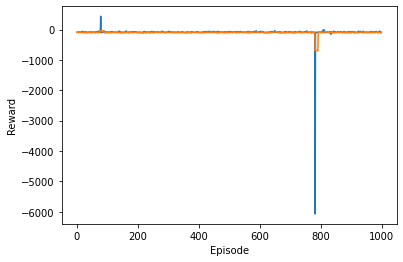

In [7]:
rewards = []
avg_rewards = []

for episode in tqdm(range(NUM_EPISODES)):
    time_step = env.reset()
    state = parse_obs(time_step.observation)
    noise.reset()
    episode_reward = 0
    episode_reward_history = []
    for step in range(DURATION):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        try:
            time_step_2 = env.step(denorm(action))
        except:
            print(f'Physics Error: {action}')
            break
        state_2 = parse_obs(time_step_2.observation)
        reward = time_step_2.reward
        agent.memory.push(state, action, reward, state_2, -1)
        state = state_2
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)
        episode_reward += reward
        episode_reward_history.append(reward)
    print(f"episode: {episode}, "
          f"reward: {np.round(episode_reward, decimals=2)}, "
          f"average_reward: {np.mean(rewards[-10:])}")
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

agent.save(PATH_MODEL)

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [8]:
def memory_policy():
    t = 0

    def policy(time_step):
        nonlocal t
        state = parse_obs(time_step.observation)
        action = agent.get_action(state)
        action = noise.get_action(action, t)
        action = denorm(action)
        t += 1
        return action

    return policy


policy = memory_policy()
viewer.launch(env, policy=policy)